In [1650]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import datetime

from helper import make_alphas_state_matrix_with_day_step
from helper import instrument_return, merge_zeros
from helper import AlphaStats, calc_alphas_corr, std, alpha_income
from helper import normalize, neutralize, neutralize_with_dropout

import manipulate_alpha as mpa

from test import test1, test2, test3
from typing import NamedTuple

SLICE_INDEX = 2436

In [2]:
def decay (alpha_matrix, n): # decrease turnover
    
    factors = (np.arange(1, n + 2)) / (n+1)

    _new_alpha_states = alpha_matrix.copy()

    for idx in range(n+1, len(alpha_matrix)):
        _alpha = alpha_matrix[idx-n-1:idx] * np.array([factors]).T
        if not np.array_equal(_alpha, np.zeros_like(_alpha)):
            _new_alpha_states[idx] = _alpha.sum(axis=0)
    
    # return _alpha
    return _new_alpha_states 

In [3]:
def ts_correlation(x, y):
    corr_vec = np.zeros(x.shape[1])

    for idx, (_x, _y) in enumerate(zip(x, y)):
        corr_vec[idx] = calc_alphas_corr(_x, _y)

    return corr_vec

In [4]:
class Alphas_Data(NamedTuple):
    name: str
    cumpnl: np.array

In [5]:
def check_alpha_correlations(alphas, cumpnl_vec):
    for alpha in alphas:
        print(f'{alpha.name}:\t{calc_alphas_corr(alpha.cumpnl, cumpnl_vec)}')

In [1623]:
alphas = []

In [7]:
class Alpha:
    def __init__(self):
        self.alpha = None
        self.zeros = None
        self.pipline = None

    def build_alpha(self):
        pass

# Creat Dataset

In [8]:
dataset_dir = './USA_2010-2014_HLOCV'
os.listdir(dataset_dir)

['Open.csv', 'High.csv', 'Close.csv', 'Low.csv', 'Volume.csv']

In [9]:
open_df = pd.read_csv(dataset_dir + '/Open.csv')
high_df = pd.read_csv(dataset_dir + '/High.csv')
close_df = pd.read_csv(dataset_dir + '/Close.csv')
low_df = pd.read_csv(dataset_dir + '/Low.csv')
volume_df = pd.read_csv(dataset_dir + '/Volume.csv')

In [1013]:
INSTRUMENTS_RETURN = instrument_return(close_df)

## Mean-reversion alpha

$-ln\frac{open(d)}{close(d-1)}$

In [10]:
day_step = 5

In [11]:
def make_mean_reversion_alpha(close_df, open_df, day_step):
    close = close_df.drop(close_df.columns[0], axis=1).to_numpy().T
    open = open_df.drop(open_df.columns[0], axis=1).to_numpy().T

    alpha = -np.log(open[day_step:] / close[:-day_step])
    return np.concatenate((np.zeros((day_step, alpha.shape[1])), alpha))

In [1568]:
mean_reversion_alpha = make_mean_reversion_alpha(close_df, open_df, day_step)

mean_reversion_alpha = neutralize(mean_reversion_alpha)
mean_reversion_alpha = normalize(mean_reversion_alpha)

In [13]:
test1(mean_reversion_alpha)
test2(mean_reversion_alpha[day_step:])

Neutrality test passed
Normality test passed


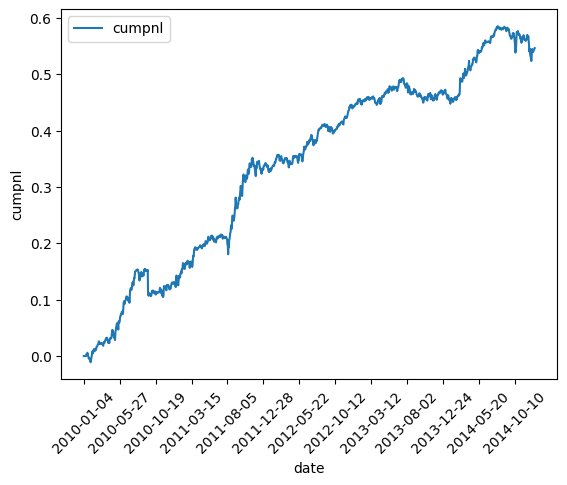

[0.1308669201439553, 0.33824420843925607, 0.4431820101032708, 0.47089746889906886, 0.5464607885449287]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,1.837308,0.703284,0.049820,0.130867
1,2011,2.633132,0.715459,0.035109,0.338244
2,2012,2.317057,0.712227,0.022373,0.443182
3,2013,0.610508,0.706987,0.043365,0.470897
4,2014,1.155745,0.704996,0.061401,0.546461


In [14]:
mean_rev_alpha_data, mean_rev_alpha_cumpnl = AlphaStats(mean_reversion_alpha, close_df)
mean_rev_alpha_data.head()

In [15]:
test3(mean_rev_alpha_data)

Sharpe test passed
Turnover test passed
Cumpnl test passed
passed 3 out of 3 tests


In [1180]:
mean_rev_alpha_pnl = alpha_income(mean_reversion_alpha, INSTRUMENTS_RETURN)

In [1571]:
# alphas.append(Alphas_Data('mean_reverse', mean_rev_alpha_pnl))

## Momentum alpha

$ln\frac{close(d-1)}{open(d-1)}$

In [1014]:
def make_momentum_alpha(close_df, open_df, day_step):
    close = close_df.drop(close_df.columns[0], axis=1).to_numpy().T
    open = open_df.drop(open_df.columns[0], axis=1).to_numpy().T

    alpha = -np.log(close[day_step:] / open[day_step:])
    return np.concatenate((np.zeros((day_step, alpha.shape[1])), alpha))

In [1015]:
day_step = 1

momentum_alpha = make_momentum_alpha(close_df, open_df, day_step)
# momentum_alpha, zeros_outliers = mpa.CutOutliers(momentum_alpha, 10)
# momentum_alpha = mpa.truncate_alpha(momentum_alpha, 0.01)
momentum_alpha = decay(momentum_alpha, 10)

# mean_reversion_alpha = neutralize_with_dropout(mean_reversion_alpha, zeros_outliers)
momentum_alpha = neutralize(momentum_alpha)
momentum_alpha = normalize(momentum_alpha)

In [1016]:
test1(momentum_alpha)
test2(momentum_alpha[day_step:])

Neutrality test passed
Normality test passed


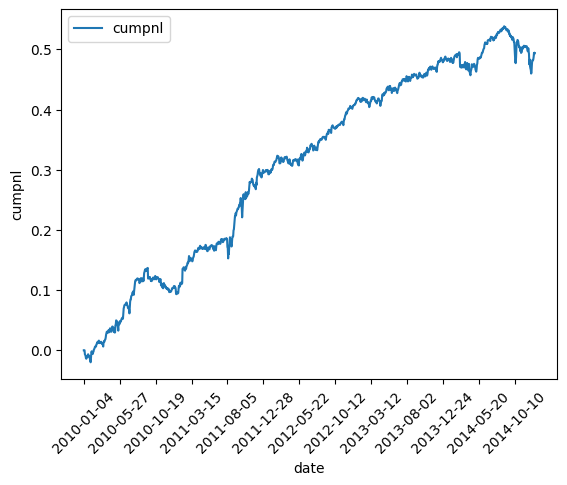

[0.10667187247012967, 0.2959947421271978, 0.4075513846417139, 0.48487781283745857, 0.4940958135443946]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,2.040933,0.525302,0.040283,0.106672
1,2011,2.687171,0.485311,0.033744,0.295995
2,2012,2.869244,0.477292,0.016937,0.407551
3,2013,2.011067,0.479547,0.015440,0.484878
4,2014,0.146339,0.487745,0.078618,0.494096


In [1017]:
momentum_alpha_data, momentum_alpha_cumpnl = AlphaStats(momentum_alpha, close_df)
momentum_alpha_data.head()

In [21]:
test3(momentum_alpha_data)

Sharpe test passed
Turnover test passed
Cumpnl test passed
passed 3 out of 3 tests


In [1022]:
momentum_alpha_pnl = alpha_income(momentum_alpha, INSTRUMENTS_RETURN)

In [1182]:
check_alpha_correlations(alphas, momentum_alpha_pnl)

mean_reverse:	0.6541873462289577


In [1624]:
alphas.append(Alphas_Data('momentum_alpha', momentum_alpha_pnl))

## Alpha 1

**(rank(Ts_ArgMax(SignedPower(((returns < 0) ? stddev(returns, 20) : close), 2.), 5)) - 0.5)**

In [1025]:
def make_alpha_1(close_df, day_step):
    close = close_df.drop(close_df.columns[0], axis=1).to_numpy().T
    return_matrix = instrument_return(close_df)

    alpha = np.zeros((close.shape))

    for i in range(day_step, len(close)):
        alpha[i] += np.where(return_matrix[i] > 0, std(return_matrix[i-day_step:i]), close[i])**2.

    sub_alpha = np.zeros((close.shape))

    for i in range(5, len(alpha)):
        sub_alpha[i] += np.argmax(alpha[i-5:i], axis=0)# - 0.5

    for i in range(day_step+1, len(close)):
        alpha[i] = mpa.rank(sub_alpha[i]) - 0.5

    return -alpha

In [1217]:
alpha_1 = make_alpha_1(close_df, 20)
alpha_1 = decay(alpha_1, 5)
# alpha_1, zeros = mpa.CutMiddle(alpha_1, 5)
alpha_1 = mpa.truncate_alpha(alpha_1, 0.01)

In [1218]:
# alpha_1 = neutralize_with_dropout(alpha_1, zeros)
alpha_1 = neutralize(alpha_1)
alpha_1 = normalize(alpha_1)

In [1219]:
test1(alpha_1)
test2(alpha_1[20:])

Neutrality test passed
Normality test is not passed


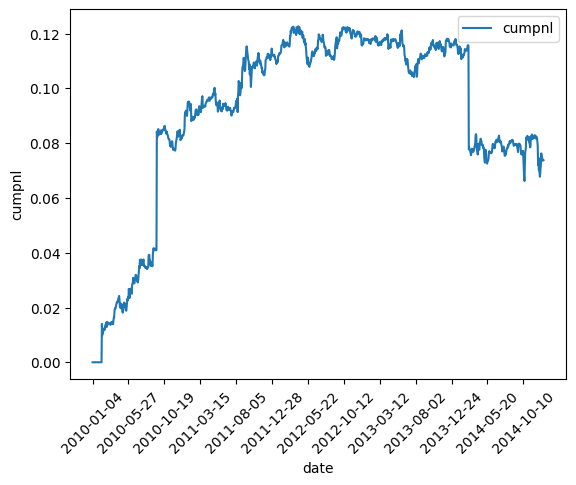

[0.08283883181853892, 0.11197743753931633, 0.11627473719064461, 0.11570186295823218, 0.07382048780316719]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,1.720611,0.366438,0.009038,0.082839
1,2011,1.272177,0.379674,0.014840,0.111977
2,2012,0.267969,0.382880,0.014819,0.116275
3,2013,-0.036218,0.390857,0.017057,0.115702
4,2014,-0.971066,0.388237,0.051858,0.073820


In [1220]:
alpha_1_data, alpha_1_cumpnl = AlphaStats(alpha_1, close_df)
alpha_1_data.head()

In [1221]:
test3(alpha_1_data)

Sharpe test not passed
Turnover test passed
Cumpnl test not passed
passed 1 out of 3 tests


In [1222]:
alpha_1_pnl = alpha_income(alpha_1, INSTRUMENTS_RETURN)

In [1223]:
check_alpha_correlations(alphas, alpha_1_pnl)

mean_reverse:	-0.1353332743191089
momentum_alpha:	0.23924988086719798


In [1250]:
# alphas.append(Alphas_Data('alpha_1', alpha_1_pnl))

## Alpha2

**(-1 * correlation(rank(delta(log(volume), 2)), rank(((close - open) / open)), 6))**

In [1033]:
def make_alpha_2(close_df, open_df, volume_df):
    close = close_df.drop(close_df.columns[0], axis=1).to_numpy().T
    open = open_df.drop(open_df.columns[0], axis=1).to_numpy().T
    volume = volume_df.drop(volume_df.columns[0], axis=1).to_numpy().T

    _alpha = (close - open) / open
    log_vol = np.where(volume == 0, volume, np.log(volume))
    delta = log_vol[2:] - log_vol[:-2]
    # delta = np.log(volume[2:]) - np.log(volume[:-2])

    sub_alpha = np.zeros_like(_alpha)
    for i in range(len(_alpha)):
        sub_alpha[i] = mpa.rank(_alpha[i])

    sub_delta = np.zeros_like(delta)
    for i in range(len(delta)):
        sub_delta[i] = mpa.rank(delta[i])
    
    alpha = np.zeros_like(delta)
    for i in range(6, len(delta)):
        alpha[i] = -1 * ts_correlation(sub_delta[i-6:i], sub_alpha[2+i-6:2+i])

    return np.concatenate((np.zeros((2, _alpha.shape[1])), alpha))

In [1226]:
alpha_2 = make_alpha_2(close_df, open_df, volume_df)

# alpha_2 = mpa.crop(alpha=alpha_2,treshold=0.075)
alpha_2 = mpa.decay(alpha_2, 10)
alpha_2 = mpa.truncate_alpha(alpha_2, 0.1)

# alpha_2, zeros = mpa.CutMiddle(alpha_2, 4)
# alpha_2 = neutralize_with_dropout(alpha_2, zeros)
alpha_2 = neutralize(alpha_2)
alpha_2 = normalize(alpha_2)

test1(alpha_2)
test2(alpha_2[9:])

/var/folders/xx/x_6wt9hs2vq2twldfgptb5840000gn/T/ipykernel_37652/2343749800.py:7: RuntimeWarning: divide by zero encountered in log
  log_vol = np.where(volume == 0, volume, np.log(volume))


Neutrality test passed
Normality test is not passed


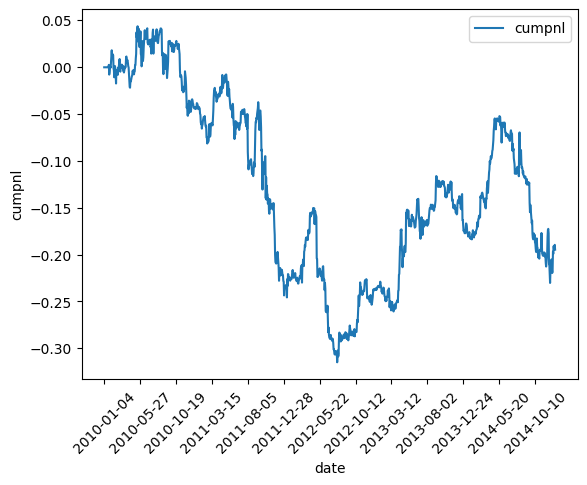

[-0.04393454620930805, -0.23521753400427603, -0.23728341135061518, -0.17709335876289403, -0.19464713830022384]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,-0.400378,0.350131,0.095577,-0.043935
1,2011,-1.453021,0.418327,0.235855,-0.235218
2,2012,-0.021140,0.268552,0.164681,-0.237283
3,2013,0.645262,0.327662,0.061001,-0.177093
4,2014,-0.164746,0.342957,0.178090,-0.194647


In [1227]:
alpha_2_data, alpha_2_cumpnl = AlphaStats(alpha_2, close_df)
alpha_2_data.head()

In [1228]:
test3(alpha_2_data)

Sharpe test not passed
Turnover test passed
Cumpnl test not passed
passed 1 out of 3 tests


In [1086]:
alpha_2_pnl = alpha_income(alpha_2, INSTRUMENTS_RETURN)

In [1087]:
check_alpha_correlations(alphas, alpha_2_pnl)

mean_reverse:	0.043446202154947655
momentum_alpha:	0.07262552001553964
alpha_1:	0.04691973749337157


In [1249]:
# alphas.append(Alphas_Data('alpha_2', alpha_2_pnl))

# Alpha 3

**(-1 * correlation(rank(open), rank(volume), 10))**

In [1035]:
def make_alpha_3(open_df, volume_df, day_step):
    volume = volume_df.drop(volume_df.columns[0], axis=1).to_numpy().T
    open = open_df.drop(open_df.columns[0], axis=1).to_numpy().T

    _open = np.zeros_like(open)
    _volume = np.zeros_like(volume)

    for idx, (x, y) in enumerate(zip(open, volume)):
        _open[idx] = mpa.rank(x)
        _volume[idx] = mpa.rank(y)

    alpha = np.zeros((open.shape))

    for i in range(day_step, len(volume)):
        alpha[i] = -1 * ts_correlation(_open[i-day_step: i], _volume[i-day_step: i])

    return alpha

In [1605]:
day_step = 10

alpha_3 = -make_alpha_3(open_df, volume_df, day_step)
# alpha_3 = mpa.truncate_alpha(alpha_3, 0.05)

alpha_3, zeros = mpa.CutMiddle(alpha_3, 20)
alpha_3, zeros_middles = mpa.CutOutliers(alpha_3, 4)
zeros = merge_zeros(zeros, zeros_middles)
alpha_3 = mpa.truncate_with_drop_out(alpha_3, zeros, 0.03)
alpha_3 = neutralize_with_dropout(alpha_3, zeros)
# alpha_3 = neutralize(alpha_3)
alpha_3 = normalize(alpha_3)

test1(alpha_2)
test2(alpha_2[day_step+1:])

Neutrality test passed
Normality test passed


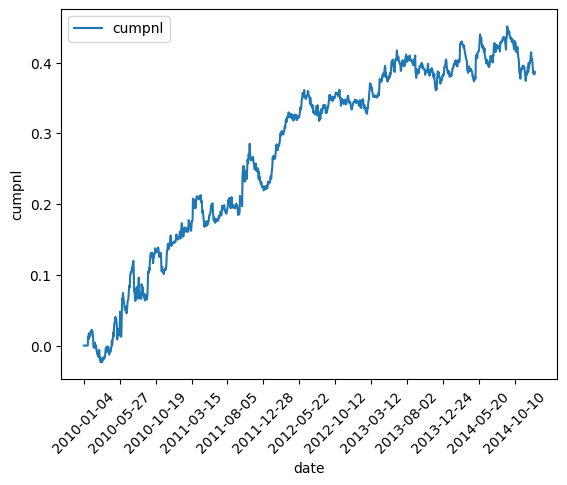

[0.14685177077937348, 0.2219440839508624, 0.3443255059482522, 0.3937482440219757, 0.38691002899396154]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,1.329635,0.663093,0.056542,0.146852
1,2011,0.799856,0.669847,0.065896,0.221944
2,2012,2.020360,0.540916,0.043561,0.344326
3,2013,0.701044,0.501456,0.056235,0.393748
4,2014,-0.087378,0.529959,0.077226,0.386910


In [1606]:
alpha_3_data, alpha_3_cumpnl = AlphaStats(alpha_3, close_df)
alpha_3_data.head()

In [1607]:
test3(alpha_3_data)

Sharpe test not passed
Turnover test passed
Cumpnl test passed
passed 2 out of 3 tests


In [1608]:
alpha_3_pnl = alpha_income(alpha_3, INSTRUMENTS_RETURN)

In [1609]:
check_alpha_correlations(alphas, alpha_3_pnl)

mean_reverse:	0.014524314930282514
momentum_alpha:	-0.04166141494282541
alpha_3:	0.971784728504321
alpha_4:	0.0280037836231019
alpha_7:	0.05052704898227467
alpha_8:	0.027395299218835704
alpha_9:	-0.03230727719931189
alpha_10:	-0.04326075035143603
alpha_13:	0.08935202595545325
alpha_14:	0.0071968321356487615
alpha_15:	0.014034636379879102
alpha_16:	0.03606043393771709
alpha_17:	0.013042560318898569
alpha_20:	0.014177883649458997
alpha_23:	0.04044238398311901
alpha_28:	0.06392841162373814


In [1625]:
alphas.append(Alphas_Data('alpha_3', alpha_3_pnl))

## Alpha 4

**(-1 * Ts_Rank(rank(low), 9))**

In [49]:
def ts_rank(time_series):
    result = np.zeros(time_series.shape[1])

    for i in range(len(result)):
        result[i] = mpa.rank(time_series.T[i])[-1]

    return result

In [1000]:
def make_alpha_4(low_df, day_step):
    low = low_df.drop(low_df.columns[0], axis=1).to_numpy().T

    low_ranked = np.zeros((low.shape))
    for idx, _low in enumerate(low):
        low_ranked[idx] = mpa.rank(_low)

    alpha = np.zeros_like(low)
    for i in range(day_step, len(low_ranked)):
        alpha[i] = -1 * ts_rank(low_ranked[i-9:i])
        
    # return np.concatenate((np.zeros((day_step, low_ranked.shape[1])), low_ranked[day_step:]))
    # return alpha
    return - low

In [1241]:
day_step = 9

alpha_4 = make_alpha_4(low_df, day_step)

alpha_4 = mpa.decay(alpha_4, 3)

alpha_4, zeros = mpa.CutMiddle(alpha_4, 10)
alpha_4, zeros_middles = mpa.CutOutliers(alpha_4, 2)
zeros = merge_zeros(zeros, zeros_middles)

alpha_4 = mpa.truncate_with_drop_out(alpha_4, zeros, 0.01)

alpha_4 = neutralize_with_dropout(alpha_4, zeros)

# alpha_4 = neutralize(alpha_4)
alpha_4 = normalize(alpha_4)

In [1242]:
test1(alpha_4)
test2(alpha_4[day_step+1:])

Neutrality test passed
Normality test passed


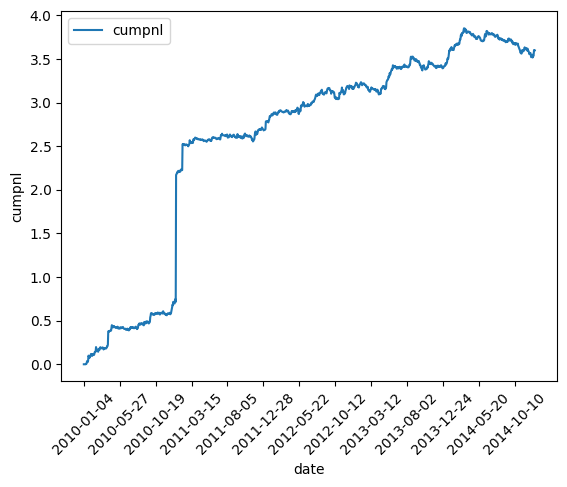

[0.6972706637007364, 2.687166678380151, 3.1802755152199933, 3.420874871396719, 3.600220046269663]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,2.972189,0.100525,0.059104,0.697271
1,2011,1.332858,0.074644,0.090673,2.687167
2,2012,2.147134,0.090232,0.129581,3.180276
3,2013,1.146539,0.080803,0.159080,3.420875
4,2014,0.805518,0.062378,0.335205,3.600220


In [1243]:
alpha_4_data, alpha_4_cumpnl = AlphaStats(alpha_4, close_df)
alpha_4_data.head()

In [1244]:
test3(alpha_4_data)

Sharpe test passed
Turnover test passed
Cumpnl test passed
passed 3 out of 3 tests


In [1245]:
alpha_4_pnl = alpha_income(alpha_4, INSTRUMENTS_RETURN)

In [1246]:
check_alpha_correlations(alphas, alpha_4_pnl)

mean_reverse:	0.11550493119888006
momentum_alpha:	0.0006244363270502071
alpha_3:	0.02631839238521295


In [1626]:
alphas.append(Alphas_Data('alpha_4', alpha_4_pnl))

## Alpha 6

(-1 * correlation(open, volume, 10)) можно применять как фильтр

In [1059]:
def make_alpha_6(open_df, volume_df, day_step):
    volume = volume_df.drop(volume_df.columns[0], axis=1).to_numpy().T
    open = open_df.drop(open_df.columns[0], axis=1).to_numpy().T

    alpha = np.zeros((open.shape))

    for i in range(day_step, len(open)):
        alpha[i] = -1 * ts_correlation(open[i-day_step:i], volume[i-day_step:i])

    return alpha

In [1060]:
day_step = 10

alpha_6 = make_alpha_6(open_df, volume_df, day_step)

alpha_6 = mpa.truncate_alpha(alpha_6, 0.1)

alpha_6 = neutralize(alpha_6)
alpha_6 = normalize(alpha_6)

alpha_6.shape

(1257, 2436)

In [1061]:
test1(alpha_6)
test2(alpha_6[day_step:])

Neutrality test passed
Normality test passed


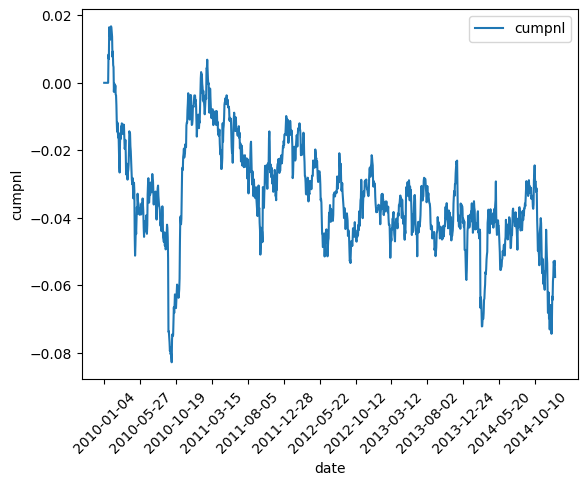

[-0.003747005594546049, -0.015326872416214356, -0.029844255115563538, -0.04949423301364235, -0.05750899693367742]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,-0.069480,0.075045,0.099502,-0.003747
1,2011,-0.226437,0.063140,0.057725,-0.015327
2,2012,-0.363843,0.066375,0.043533,-0.029844
3,2013,-0.454123,0.059464,0.026454,-0.049494
4,2014,-0.147596,0.064519,0.049880,-0.057509


In [1062]:
alpha_6_data, alpha_6_cumpnl = AlphaStats(alpha_6, close_df)
alpha_6_data.head()

In [1063]:
test3(alpha_6_data)

Sharpe test not passed
Turnover test passed
Cumpnl test not passed
passed 1 out of 3 tests


In [1091]:
alpha_6_pnl = alpha_income(alpha_6, INSTRUMENTS_RETURN)

In [1092]:
check_alpha_correlations(alphas, alpha_6_pnl)

mean_reverse:	0.022217666332029724
momentum_alpha:	0.08706694259713985
alpha_1:	-0.005470644086178894
alpha_4:	-0.06008562221583484


In [1248]:
# alphas.append(Alphas_Data('alpha_6', alpha_6_pnl))

## Alpha 7

((adv20 < volume) ? ((-1 * ts_rank(abs(delta(close, 7)), 60)) * sign(delta(close, 7))) : (-1 * 1))

In [1064]:
def average_dayly_volume(volume, day_step):
    adv = np.zeros_like(volume)

    for i in range(day_step, len(volume)):
        adv[i] = volume[i-day_step:i].mean(axis=0)

    return adv

In [1065]:
def make_alpha_7(volume_df, close_df):
    volume = volume_df.drop(volume_df.columns[0], axis=1).to_numpy().T
    close = close_df.drop(close_df.columns[0], axis=1).to_numpy().T
    
    adv = average_dayly_volume(volume, 20)

    close_delta = np.concatenate((np.zeros((7, close.shape[1])), close[7:] - close[:-7]))

    alpha = np.zeros_like(volume)
    for i in range(60+7, len(alpha)):
        alpha[i] = np.where(adv[i] < volume[i], -1. * ts_rank(np.abs(close_delta[i-60:i])) * np.sign(close_delta)[i], -1.)      
                    

    return alpha
        

In [1066]:
alpha_7 = make_alpha_7(volume_df, close_df)

In [1067]:
_alpha_7 = decay(alpha_7, 5) + 0.1

# _alpha_7, zeros = mpa.CutOutliers(_alpha_7, 2)
# _alpha_7 = mpa.neutralize_with_dropout(_alpha_7, zeros)
_alpha_7 = neutralize(_alpha_7)
_alpha_7 = normalize(_alpha_7)

test1(_alpha_7)
test2(_alpha_7[60+7:])

Neutrality test is not passed
Normality test passed


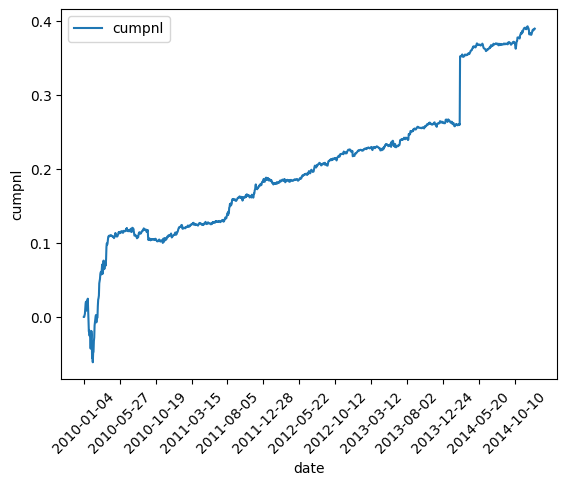

[0.11099101248292212, 0.18273034701083585, 0.21765087660183846, 0.26178191206334844, 0.3895849988482419]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,1.445262,0.416303,0.085912,0.110991
1,2011,3.116425,0.568193,0.006531,0.182730
2,2012,1.894785,0.556693,0.009266,0.217651
3,2013,2.246489,0.551699,0.008723,0.261782
4,2014,1.354793,0.540781,0.011611,0.389585


In [1068]:
alpha_7_data, alpha_7_cumpnl = AlphaStats(_alpha_7, close_df)
alpha_7_data.head()

In [1069]:
test3(alpha_7_data)

Sharpe test passed
Turnover test passed
Cumpnl test passed
passed 3 out of 3 tests


In [1251]:
alpha_7_pnl = alpha_income(alpha_7, INSTRUMENTS_RETURN)

In [1252]:
check_alpha_correlations(alphas, alpha_7_pnl)

mean_reverse:	-0.04189680599049322
momentum_alpha:	-0.160513679099381
alpha_3:	0.049265496927399385
alpha_4:	1.7111476822907238e-05


In [1576]:
# alphas.append(Alphas_Data('alpha_7', alpha_7_pnl))

## Alpha 8

**(-1 * rank(((sum(open, 5) * sum(returns, 5)) - delay((sum(open, 5) * sum(returns, 5)), 10))))**

In [1073]:
def make_alpha_8(open_df, close_df, sum_window=5, delay_window=10):
    close = close_df.drop(close_df.columns[0], axis=1).to_numpy().T
    open = open_df.drop(open_df.columns[0], axis=1).to_numpy().T
    
    return_matrix = instrument_return(close_df)

    open_sums = np.zeros(open.shape)
    returns_sums = np.zeros_like(return_matrix)
    for i in range(sum_window, len(open_sums)):
        open_sums[i] = open[i-sum_window:i].sum(axis=0)
        returns_sums[i] = return_matrix[i-sum_window:i].sum(axis=0)

    multy = returns_sums * open_sums

    alpha = np.zeros(open.shape)
    for i in range(delay_window, len(alpha)):
        alpha[i] = -1 * mpa.rank(multy[i] - multy[i-delay_window])

    return alpha

In [1074]:
sum_step = 5
delay_step = 10

alpha_8 = make_alpha_8(open_df, close_df, sum_step, delay_step)

In [1075]:
_alpha_8 = alpha_8
_alpha_8, zeros = mpa.CutOutliers(_alpha_8, 2)
_alpha_8 = -mpa.truncate_with_drop_out(_alpha_8, zeros, 0.003)
_alpha_8 = mpa.neutralize_with_dropout(_alpha_8, zeros)
# _alpha_8 = neutralize(_alpha_8)
_alpha_8 = normalize(_alpha_8)

test1(_alpha_8)
test2(_alpha_8[delay_step:])

Neutrality test passed
Normality test passed


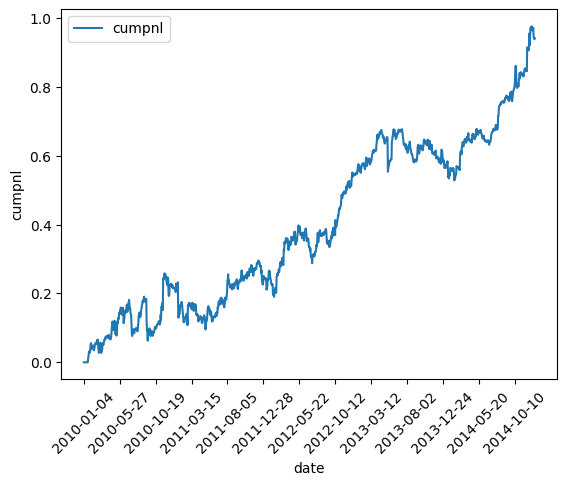

[0.21567791023768135, 0.2449424359184836, 0.5478480661426987, 0.565231869148634, 0.9420230765316526]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,1.111593,0.540338,0.127807,0.215678
1,2011,0.164305,0.570298,0.137142,0.244942
2,2012,1.764138,0.551990,0.109984,0.547848
3,2013,0.103773,0.545218,0.121530,0.565232
4,2014,2.235594,0.545141,0.064390,0.942023


In [1076]:
alpha_8_data, alpha_8_cumpnl = AlphaStats(_alpha_8, close_df)
alpha_8_data.head()

In [1077]:
test3(alpha_8_data)

Sharpe test passed
Turnover test passed
Cumpnl test passed
passed 3 out of 3 tests


In [1254]:
alpha_8_pnl = alpha_income(alpha_8, INSTRUMENTS_RETURN)

In [1610]:
check_alpha_correlations(alphas, alpha_8_pnl)

mean_reverse:	-0.15293101706080978
momentum_alpha:	-0.24047376285597188
alpha_3:	0.02598954602258157
alpha_4:	-0.015571830301229684
alpha_7:	0.8533228089651622
alpha_8:	1.0
alpha_9:	-0.9863952448501155
alpha_10:	-0.5606752208515934
alpha_13:	0.24075128231774087
alpha_14:	-0.1225841971207983
alpha_15:	-0.23757324643823186
alpha_16:	-9.065923384309025e-05
alpha_17:	-0.49942536304564644
alpha_20:	-0.20819634932163344
alpha_23:	0.06796478177119485
alpha_28:	-0.16932104720181032


In [1627]:
alphas.append(Alphas_Data('alpha_8', alpha_8_pnl))

## Alpha 9

**((0 < ts_min(delta(close, 1), 5)) ? delta(close, 1) : ((ts_max(delta(close, 1), 5) < 0) ? delta(close, 1) : (-1 * delta(close, 1))))**

In [98]:
def ts_min(matrix):
    return np.min(matrix, axis=0)

In [99]:
def ts_max(matrix):
    return np.max(matrix, axis=0)

In [100]:
def make_alpha_9(close_df, min_max_window=10, delta_window=1):
    close = close_df.drop(close_df.columns[0], axis=1).to_numpy().T

    _close = np.concatenate((np.zeros((1, close.shape[1])), close[delta_window:] - close[:-delta_window]))

    alpha = np.zeros_like(close)
    for i in range(min_max_window+delta_window, len(alpha)):
        alpha[i] = np.where(ts_min(_close[i-min_max_window: i]) > 0, 
                            _close[i], 
                            np.where(ts_max(_close[i-min_max_window:i]) < 0, _close[i], -1 * close[i]))

    return alpha

In [1611]:
min_max_window = 7
delta_window = 1

alpha_9 = make_alpha_9(close_df, min_max_window, delta_window)
# alpha_9 = mpa.truncate_alpha(alpha_9, 0.3)
alpha_9 = decay(alpha_9, 5)
alpha_9, zeros = mpa.CutOutliers(alpha_9, 4)
alpha_9 = mpa.truncate_with_drop_out(alpha_9, zeros, 0.01)

alpha_9 = neutralize_with_dropout(alpha_9, zeros)
# alpha_9 = neutralize(alpha_9)
alpha_9 = normalize(alpha_9)

test1(alpha_9)
test2(alpha_9[min_max_window+delta_window:])

Neutrality test is not passed
Normality test passed


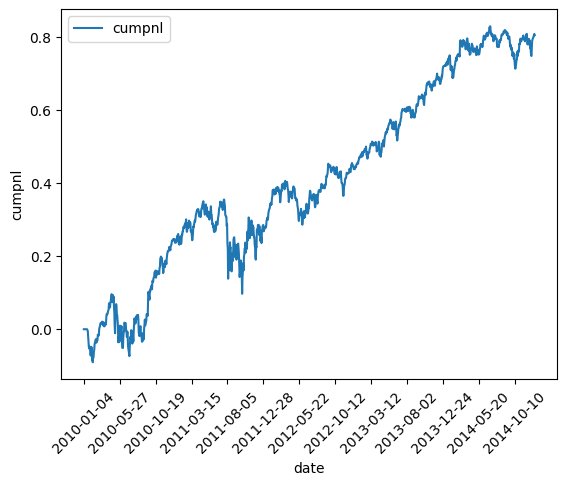

[0.2470400122679548, 0.2788725756798132, 0.43857231454336176, 0.7208987731689591, 0.8057280094367509]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,1.189361,0.099241,0.169644,0.247040
1,2011,0.115741,0.037981,0.258059,0.278873
2,2012,1.138087,0.000804,0.120145,0.438572
3,2013,2.426831,0.079386,0.057353,0.720899
4,2014,0.646108,0.088058,0.116387,0.805728


In [1612]:
alpha_9_data, alpha_9_cumpnl = AlphaStats(alpha_9, close_df)
alpha_9_data.head()

In [1613]:
test3(alpha_9_data)

Sharpe test passed
Turnover test passed
Cumpnl test passed
passed 3 out of 3 tests


In [1614]:
alpha_9_pnl = alpha_income(alpha_9, INSTRUMENTS_RETURN)

In [1615]:
check_alpha_correlations(alphas, alpha_9_pnl)

mean_reverse:	0.20932979445525554
momentum_alpha:	0.3115816805985858
alpha_3:	-0.030105990276885285
alpha_4:	-0.0012246196094217769
alpha_7:	-0.8413982742072202
alpha_8:	-0.9863952448501155
alpha_9:	1.0
alpha_10:	0.5652131259006837
alpha_13:	-0.2549471009928922
alpha_14:	0.17248775231316238
alpha_15:	0.22588591724738438
alpha_16:	-0.0156880241564674
alpha_17:	0.4795534623957456
alpha_20:	0.22680808408602185
alpha_23:	-0.06222648809062381
alpha_28:	0.13428076023721017


In [1616]:
# alphas.append(Alphas_Data('alpha_9', alpha_9_pnl))

## Alpha 10

**rank(((0 < ts_min(delta(close, 1), 4)) ? delta(close, 1) : ((ts_max(delta(close, 1), 4) < 0) ? delta(close, 1) : (-1 * delta(close, 1)))))**

In [1617]:
def make_alpha_10(close_df, min_max_window=4, delta_window=1):
    close = close_df.drop(close_df.columns[0], axis=1).to_numpy().T

    _close = np.concatenate((np.zeros((1, close.shape[1])), close[delta_window:] - close[:-delta_window]))

    sub_alpha = np.zeros_like(close)

    for i in range(min_max_window+delta_window, len(sub_alpha)):
        sub_alpha[i] = mpa.rank(np.where(ts_min(_close[i-min_max_window:i]) > 0, 
                                _close[i], 
                                np.where(ts_max(_close[i-min_max_window: i])<0, _close[i], -1 * _close[i])))

    return sub_alpha

In [1618]:
min_max_window = 4
delta_window = 1

alpha_10 = make_alpha_10(close_df, min_max_window, delta_window)

alpha_10 = decay(alpha_10, 5)
alpha_10 = mpa.truncate_alpha(alpha_10, 0.1)

alpha_10 = neutralize(alpha_10)
alpha_10 = normalize(alpha_10)

test1(alpha_10)
test2(alpha_10[min_max_window+delta_window:])

Neutrality test is not passed
Normality test passed


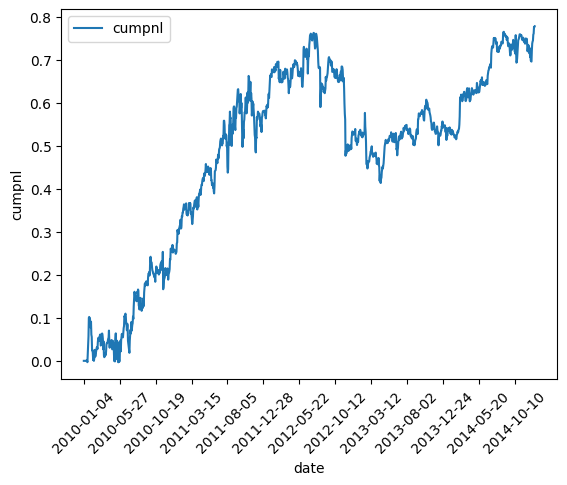

[0.25721230435726233, 0.5822300053539846, 0.5314314033808422, 0.5481305446544971, 0.7788554984371842]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,1.074813,0.404759,0.105576,0.257212
1,2011,1.242904,0.350414,0.178083,0.582230
2,2012,-0.226305,0.348898,0.286075,0.531431
3,2013,0.111365,0.342324,0.163250,0.548131
4,2014,1.548822,0.426537,0.071845,0.778855


In [1619]:
alpha_10_data, alpha_10_cumpnl = AlphaStats(alpha_10, close_df)
alpha_10_data.head()

In [1620]:
test3(alpha_10_data)

Sharpe test passed
Turnover test passed
Cumpnl test passed
passed 3 out of 3 tests


In [1621]:
alpha_10_pnl = alpha_income(alpha_10, INSTRUMENTS_RETURN)

In [1622]:
check_alpha_correlations(alphas, alpha_10_pnl)

mean_reverse:	0.1261025330656024
momentum_alpha:	0.18829042295403714
alpha_3:	-0.04550115501770313
alpha_4:	0.012916888932225945
alpha_7:	-0.5305778241401385
alpha_8:	-0.5606752208515934
alpha_9:	0.5652131259006837
alpha_10:	1.0
alpha_13:	-0.11725438377843869
alpha_14:	0.0981749929776538
alpha_15:	0.11589611658095134
alpha_16:	0.0006447227131728883
alpha_17:	0.21053032907562852
alpha_20:	0.15488785893282098
alpha_23:	-0.012462135071762163
alpha_28:	0.07140447979221191


In [1628]:
alphas.append(Alphas_Data('alpha_10', alpha_10_pnl))

## Alpha 11

**((rank(ts_max((vwap - close), 3)) + rank(ts_min((vwap - close), 3))) * rank(delta(volume, 3)))**

## Alpha 12

**(sign(delta(volume, 1)) * (-1 * delta(close, 1)))**

In [140]:
def make_alpha_12(volume_df, close_df, delta_window):
    close = close_df.drop(close_df.columns[0], axis=1).to_numpy().T
    volume = volume_df.drop(volume_df.columns[0], axis=1).to_numpy().T

    alpha = np.zeros_like(close)
    for i in range(delta_window, len(alpha)):
        alpha[i] = np.sign(volume[i] - volume[i-delta_window]) * (-1 * close[i] - close[i-delta_window])

    return alpha

In [1362]:
delta_window = 4

alpha_12 = -make_alpha_12(volume_df, close_df, delta_window)
alpha_12 = mpa.truncate_alpha(alpha_12, 0.3)
alpha_12 = decay(alpha_12, 3)
# alpha_12 = mpa.truncate_alpha(alpha_12, 0.01)

alpha_12 = neutralize(alpha_12)
alpha_12 = normalize(alpha_12)

test1(alpha_12)
test2(alpha_12[delta_window+1:])

Neutrality test passed
Normality test passed


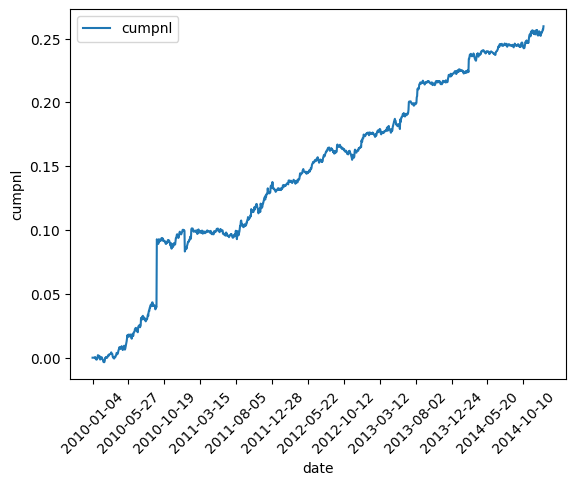

[0.10015516677563427, 0.13275093102619995, 0.17186331379243044, 0.22254386329756748, 0.25960120459142644]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,1.783107,0.757986,0.008345,0.100155
1,2011,1.157288,0.771545,0.016957,0.132751
2,2012,2.414598,0.773705,0.011932,0.171863
3,2013,2.666789,0.767382,0.007984,0.222544
4,2014,1.987449,0.762282,0.005664,0.259601


In [1363]:
alpha_12_data, alpha_12_cumpnl = AlphaStats(alpha_12, close_df)
alpha_12_data.head()

In [1364]:
test3(alpha_12_data)

Sharpe test passed
Turnover test passed
Cumpnl test not passed
passed 2 out of 3 tests


In [1365]:
alpha_12_pnl = alpha_income(alpha_12, INSTRUMENTS_RETURN)

In [1366]:
check_alpha_correlations(alphas, alpha_12_pnl)

mean_reverse:	-0.14132360849953465
momentum_alpha:	-0.04947157455314968
alpha_3:	0.07932265554630694
alpha_4:	-0.19572390488118657
alpha_7:	-0.0490478477181954
alpha_8:	-0.09814049829264884
alpha_9:	0.06138387765494067
alpha_10:	0.021083510712512323


In [1367]:
# alphas.append(Alphas_Data('alpha_12', alpha_12_pnl))

## Alpha 13

**(-1 * rank(covariance(rank(close), rank(volume), 5)))**

In [1368]:
def covarience(vector1, vector2):
    return np.sum((vector1 - vector1.mean()) * (vector2 - vector2.mean()), axis=0)

In [1369]:
def make_alpha_13(close_df, volume_df, cov_window):
    close = close_df.drop(close_df.columns[0], axis=1).to_numpy().T
    volume = volume_df.drop(volume_df.columns[0], axis=1).to_numpy().T

    alpha = np.zeros_like(close)

    close_ranked = np.array([mpa.rank(_close) for _close in close])
    volume_ranked = np.array([mpa.rank(_volume) for _volume in volume])

    for i in range(cov_window, len(close)):
        alpha[i] = -1* mpa.rank(covarience(close_ranked[i-cov_window:i], volume_ranked[i-cov_window:i]))

    return alpha

In [1375]:
cov_window = 5

alpha_13 = -make_alpha_13(close_df, volume_df, cov_window)

alpha_13, zeros = mpa.CutOutliers(alpha_13, 2)

alpha_13 = mpa.truncate_with_drop_out(alpha_13, zeros, 0.01)
alpha_13 = neutralize_with_dropout(alpha_13, zeros)
# alpha_13 = neutralize(alpha_13)
alpha_13 = normalize(alpha_13)

test1(alpha_13)
test2(alpha_13[cov_window+1:])

Neutrality test passed
Normality test passed


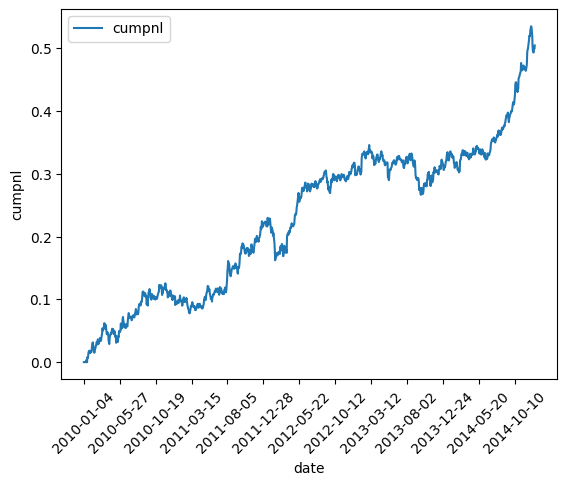

[0.1021131557820491, 0.22222181834653187, 0.3174452617509969, 0.3103840893575968, 0.5043369391617658]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,1.586844,0.028685,0.033313,0.102113
1,2011,1.852109,0.035594,0.028383,0.222222
2,2012,1.346901,0.037723,0.067601,0.317445
3,2013,-0.095849,0.036546,0.079353,0.310384
4,2014,2.854907,0.040691,0.041779,0.504337


In [1376]:
alpha_13_data, alpha_13_cumpnl = AlphaStats(alpha_13, close_df)
alpha_13_data.head()

In [1377]:
test3(alpha_13_data)

Sharpe test passed
Turnover test passed
Cumpnl test passed
passed 3 out of 3 tests


In [1378]:
alpha_13_pnl = alpha_income(alpha_13, INSTRUMENTS_RETURN)

In [1379]:
check_alpha_correlations(alphas, alpha_13_pnl)

mean_reverse:	-0.0888922303933427
momentum_alpha:	-0.1911542586228575
alpha_3:	0.08712406232724772
alpha_4:	0.005835714684117814
alpha_7:	0.20292923803936322
alpha_8:	0.24075128231774087
alpha_9:	-0.2549471009928922
alpha_10:	-0.11725438377843869


In [1629]:
alphas.append(Alphas_Data('alpha_13', alpha_13_pnl))

## Alpha 14

**((-1 * rank(delta(returns, 3))) * correlation(open, volume, 10))**

In [1381]:
def make_alpha_14(close_df, open_df, volume_df, delta_window=3, cor_window=10):
    close = close_df.drop(close_df.columns[0], axis=1).to_numpy().T
    volume = volume_df.drop(volume_df.columns[0], axis=1).to_numpy().T
    open = open_df.drop(open_df.columns[0], axis=1).to_numpy().T

    returns = instrument_return(close_df)

    alpha = np.zeros_like(close)
    for i in range(cor_window, len(alpha)):
        alpha[i] = -1 * mpa.rank(returns[i] - returns[i-delta_window]) * calc_alphas_corr(open[i-cor_window:i], 
                                                                                              volume[i-cor_window:i])

    return alpha

In [1382]:
delta_window = 3
cor_window = 15

alpha_14 = -make_alpha_14(close_df, open_df, volume_df, delta_window, cor_window)

alpha_14 = mpa.decay(alpha_14, 20)
# alpha_14, zeros = mpa.CutOutliers(alpha_14, 3)
# alpha_14 = mpa.truncate_alpha(alpha_14, 0.05)

# alpha_14 = neutralize_with_dropout(alpha_14, zeros)
alpha_14 = neutralize(alpha_14)
alpha_14 = normalize(alpha_14)

test1(alpha_14)
test2(alpha_14[cor_window:])

Neutrality test passed
Normality test is not passed


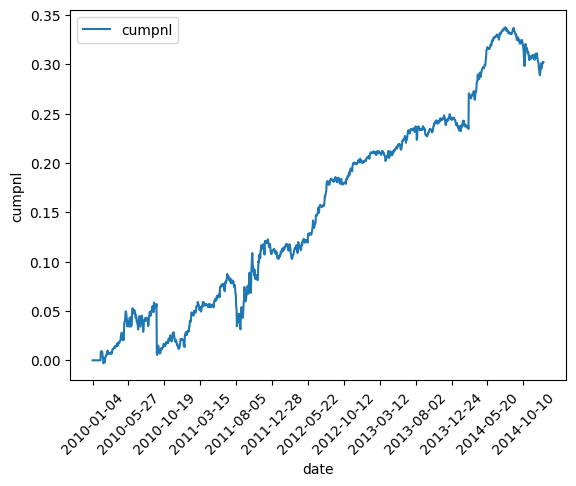

[0.02078087849373107, 0.11188033165714205, 0.2002560528700908, 0.2458544732303919, 0.3022015488704591]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,0.300346,0.719947,0.052959,0.020781
1,2011,1.394650,0.807713,0.056060,0.111880
2,2012,2.645397,0.804856,0.014965,0.200256
3,2013,1.544640,0.805610,0.013794,0.245854
4,2014,1.089434,0.804413,0.048553,0.302202


In [1383]:
alpha_14_data, alpha_14_cumpnl = AlphaStats(alpha_14, close_df)
alpha_14_data.head()

In [1384]:
test3(alpha_14_data)

Sharpe test passed
Turnover test passed
Cumpnl test passed
passed 3 out of 3 tests


In [1385]:
alpha_14_pnl = alpha_income(alpha_14, INSTRUMENTS_RETURN)

In [1386]:
check_alpha_correlations(alphas, alpha_14_pnl)

mean_reverse:	0.7246099951064181
momentum_alpha:	0.46208781438568286
alpha_3:	0.002353630769139072
alpha_4:	0.1052021633134424
alpha_7:	0.023710153303332124
alpha_8:	-0.1225841971207983
alpha_9:	0.17248775231316238
alpha_10:	0.0981749929776538
alpha_13:	-0.0760082969845017


In [1630]:
alphas.append(Alphas_Data('alpha_14', alpha_14_pnl))

## Alpha 15

**-1 * sum(rank(correlation(rank(high), rank(volume), 3)), 3)**

In [1411]:
def make_alpha_15(high_df, volume_df, cor_window=3, sum_window=3):
    volume = volume_df.drop(volume_df.columns[0], axis=1).to_numpy().T
    high = high_df.drop(high_df.columns[0], axis=1).to_numpy().T

    volume_ranked = np.array([mpa.rank(_volume) for _volume in volume])
    high_ranked = np.array([mpa.rank(_high) for _high in high])

    ranked_high_volume = np.zeros_like(volume)
    for i in range(cor_window, len(ranked_high_volume)):
        ranked_high_volume[i] = mpa.rank(ts_correlation(high_ranked[i-cor_window:i], volume_ranked[i-cor_window:i]))

    alpha = np.zeros_like(volume)
    # for i in range(max(sum_window, cor_window), len(alpha)):
    for i in range(sum_window + cor_window, len(alpha)):
        alpha[i] = -1 * np.average(ranked_high_volume[i - sum_window:i], axis=0)
        # alpha[i] = -1 * np.sum(ranked_high_volume[i - sum_window:i], axis=0)

    return alpha

In [1422]:
cor_window = 5
sum_window = 3

alpha_15 = make_alpha_15(high_df, volume_df, cor_window, sum_window)

alpha_15 = decay(alpha_15, 2)
# alpha_15 = mpa.truncate_alpha(alpha_15)

alpha_15 = neutralize(alpha_15)
alpha_15 = normalize(alpha_15)

test1(alpha_15)
test2(alpha_15[cor_window + sum_window:])
# test2(alpha_15[max(cor_window, sum_window)+1:])

Neutrality test passed
Normality test is not passed


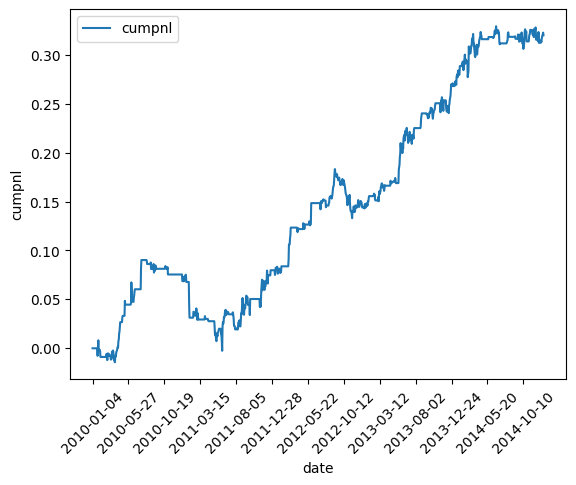

[0.06861007330369685, 0.07979958040252043, 0.14398533533958258, 0.2680536171832557, 0.3200909753236256]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,1.375841,0.099206,0.022441,0.068610
1,2011,0.174251,0.095618,0.077707,0.079800
2,2012,1.394928,0.096000,0.050166,0.143985
3,2013,2.517236,0.083333,0.016298,0.268054
4,2014,0.875210,0.071429,0.023714,0.320091


In [1423]:
alpha_15_data, alpha_15_cumpnl = AlphaStats(alpha_15, close_df)
alpha_15_data.head()

In [1424]:
test3(alpha_15_data)

Sharpe test passed
Turnover test passed
Cumpnl test passed
passed 3 out of 3 tests


In [1425]:
alpha_15_pnl = alpha_income(alpha_15, INSTRUMENTS_RETURN)

In [1426]:
check_alpha_correlations(alphas, alpha_15_pnl)

mean_reverse:	0.03592409006283838
momentum_alpha:	-0.005740286372564484
alpha_3:	0.020511883895648085
alpha_4:	0.02619427880193412
alpha_7:	-0.20880270453854272
alpha_8:	-0.23757324643823186
alpha_9:	0.22588591724738438
alpha_10:	0.11589611658095134
alpha_13:	-0.031329085555907195
alpha_14:	0.06388246607725524


In [1631]:
alphas.append(Alphas_Data('alpha_15', alpha_15_pnl))

## Alpha 16

**(-1 * rank(covariance(rank(high), rank(volume), 5)))**

In [1428]:
def make_alpha_16(high_df, volume_df, cov_window=5):
    
    volume = volume_df.drop(volume_df.columns[0], axis=1).to_numpy().T
    high = high_df.drop(high_df.columns[0], axis=1).to_numpy().T

    volume_ranked = np.array([mpa.rank(_volume) for _volume in volume])
    high_ranked = np.array([mpa.rank(_high) for _high in high])

    alpha = np.zeros_like(volume)
    for i in range(cov_window+1, len(alpha)):
        alpha[i] = -1 * mpa.rank(covarience(high_ranked[i-1-cov_window:i-1], volume_ranked[i-1-cov_window:i-1]))

    return alpha 

In [1429]:
cov_window = 5

alpha_16 = -make_alpha_16(high_df, volume_df, cov_window)

alpha_16 = neutralize(alpha_16)
alpha_16 = normalize(alpha_16)

test1(alpha_16)
test2(alpha_16[cov_window+1:])

Neutrality test passed
Normality test passed


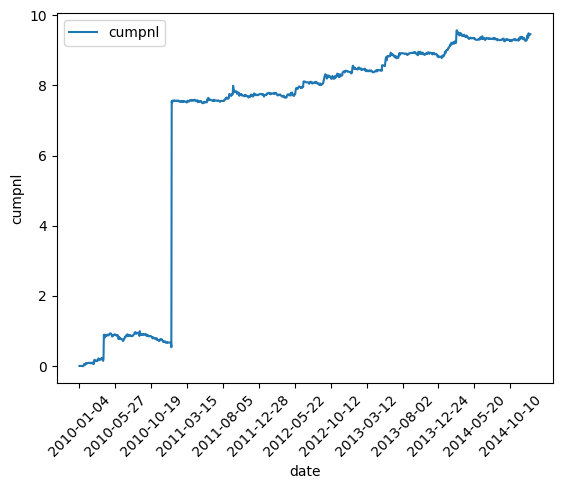

[0.6629294115378751, 7.755696167830108, 8.389956037365288, 8.822646495129963, 9.462685656028091]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,0.867842,0.158794,0.335680,0.662929
1,2011,1.009198,0.215228,0.335042,7.755696
2,2012,1.568828,0.148061,0.145494,8.389956
3,2013,1.018395,0.138946,0.188683,8.822646
4,2014,1.303797,0.131006,0.313092,9.462686


In [1430]:
alpha_16_data, alpha_16_cumpnl = AlphaStats(alpha_16, close_df)
alpha_16_data.head()

In [1431]:
test3(alpha_16_data)

Sharpe test passed
Turnover test passed
Cumpnl test passed
passed 3 out of 3 tests


In [1432]:
alpha_16_pnl = alpha_income(alpha_16, INSTRUMENTS_RETURN)

In [1433]:
check_alpha_correlations(alphas, alpha_16_pnl)

mean_reverse:	0.12649628880637798
momentum_alpha:	-0.05797946157253764
alpha_3:	0.03419524503933972
alpha_4:	0.9417796610396325
alpha_7:	0.014089397337410513
alpha_8:	-9.065923384309025e-05
alpha_9:	-0.0156880241564674
alpha_10:	0.0006447227131728883
alpha_13:	0.00149814631096662
alpha_14:	0.09856201111340172
alpha_15:	0.02499472254250182


In [1585]:
# alphas.append(Alphas_Data('alpha_16', alpha_16_pnl))

## Alpha 17

**(((-1 * rank(ts_rank(close, 10))) * rank(delta(delta(close, 1), 1))) * rank(ts_rank((volume / adv20), 5)))**

In [1435]:
def make_alpha_17(close_df, volume_df, ts_rank_close_window=10, delta_window=1, adv_window=20, ts_rank_volume_window=5):
    volume = volume_df.drop(volume_df.columns[0], axis=1).to_numpy().T
    close = close_df.drop(close_df.columns[0], axis=1).to_numpy().T

    close_ranked = np.zeros_like(close)
    for i in range(ts_rank_close_window+1, len(close)):
        close_ranked[i] = mpa.rank(ts_rank(close[i - ts_rank_close_window - 1: i]))

    delta = np.zeros_like(close)
    for i in range(delta_window+1, len(delta)):
        delta[i] = close[i-1] - close[i-1-delta_window]

    delta_close = np.zeros_like(close)
    for i in range(delta_window, len(delta_close)):
        delta_close[i] = mpa.rank(delta[i] - delta[i-1])

    volume_adv = average_dayly_volume(volume, adv_window)
    volume_ranked = np.zeros_like(volume)
    for i in range(ts_rank_volume_window+1, len(volume)):
        volume_ranked[i] = mpa.rank(ts_rank(volume_adv[i-1-ts_rank_volume_window:i-1]))

    alpha = -1 * close_ranked * delta_close * volume_ranked
    return alpha

In [1436]:
alpha_17 = make_alpha_17(close_df, volume_df)

In [1437]:
alpha_17 = neutralize(alpha_17)
alpha_17 = normalize(alpha_17)

test1(alpha_17)
test2(alpha_17[11:])

Neutrality test passed
Normality test passed


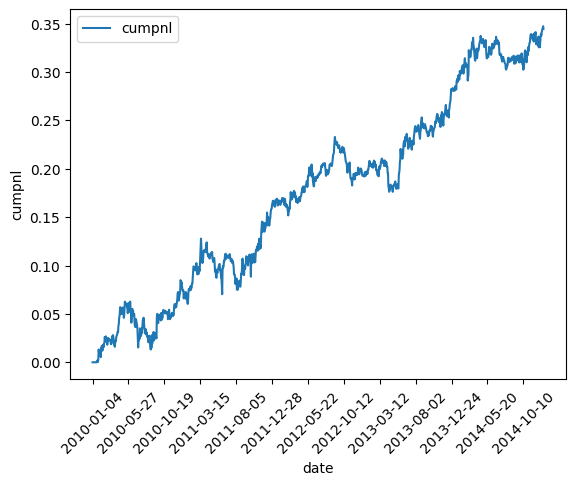

[0.07425199451369344, 0.1669025385256115, 0.19277042595045704, 0.2806307556229535, 0.3447276390218011]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,1.101602,3.968254e-03,0.049508,0.074252
1,2011,1.204732,6.393413e-17,0.057461,0.166903
2,2012,0.524828,1.005298e-16,0.050166,0.192770
3,2013,1.499680,1.166694e-16,0.034367,0.280631
4,2014,0.953910,1.070013e-16,0.034938,0.344728


In [1438]:
alpha_17_data, alpha_17_cumpnl = AlphaStats(alpha_17, close_df)
alpha_17_data.head()

In [1439]:
test3(alpha_17_data)

Sharpe test passed
Turnover test passed
Cumpnl test passed
passed 3 out of 3 tests


In [1440]:
alpha_17_pnl = alpha_income(alpha_17, INSTRUMENTS_RETURN)

In [1441]:
check_alpha_correlations(alphas, alpha_17_pnl)

mean_reverse:	0.054105062249049596
momentum_alpha:	0.05936235065033422
alpha_3:	0.010696986409219744
alpha_4:	0.024757867411168324
alpha_7:	-0.44816397729401486
alpha_8:	-0.49942536304564644
alpha_9:	0.4795534623957456
alpha_10:	0.21053032907562852
alpha_13:	-0.06701415358658416
alpha_14:	0.06644670132293402
alpha_15:	0.6009216576082849
alpha_16:	0.02183949872772255


In [1587]:
# alphas.append(Alphas_Data('alpha_17', alpha_17_pnl))

## Alpha 18

**(-1 * rank(((stddev(abs((close - open)), 5) + (close - open)) + correlation(close, open, 10))))**

In [1443]:
def rolling_std(matrix):
    std_vector = np.zeros(matrix.shape[-1])
    for i in range(len(std_vector)):
        std_vector[i] = std(matrix.T[i])

    return std_vector

In [1444]:
def make_alpha_18(close_df, open_df, std_window=5, corr_window=10):
    close = close_df.drop(close_df.columns[0], axis=1).to_numpy().T
    open = open_df.drop(open_df.columns[0], axis=1).to_numpy().T

    diff = close - open

    std_diff = np.zeros_like(close)
    for i in range(max(std_window, corr_window), len(close)):
        std_diff[i] = rolling_std(np.abs(diff[i-std_window:i])) + diff[i]

    close_open_corr = np.zeros_like(close)
    for i in range(max(std_window, corr_window), len(close)):
        close_open_corr[i] = ts_correlation(close[i-corr_window:i], open[i-corr_window:i])

    matrix = std_diff + close_open_corr
    alpha = np.zeros_like(close)
    for i in range(max(std_window, corr_window), len(close)):
        alpha[i] = mpa.rank(alpha[i])

    return -1 * alpha

In [1445]:
std_window=5
corr_window=10

alpha_18 = -make_alpha_18(close_df, open_df, std_window, corr_window)

alpha_18, zeros = mpa.CutOutliers(alpha_18, 10)

alpha_18 = neutralize_with_dropout(alpha_18, zeros)
alpha_18 = neutralize(alpha_18)
alpha_18 = normalize(alpha_18)

test1(alpha_18)
test2(alpha_18[max(std_window, corr_window):])

Neutrality test passed
Normality test passed


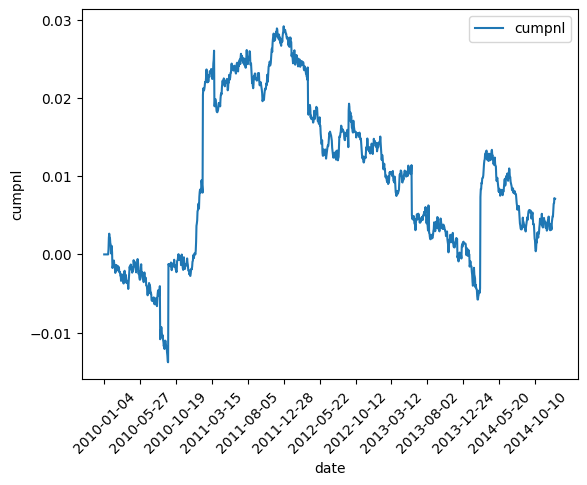

[0.00010291391921193768, 0.02870668495436006, 0.01448937438825761, 0.0013962925072625327, 0.007101667301969898]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,0.006287,0.003968,0.016442,0.000103
1,2011,1.705812,0.000000,0.007876,0.028707
2,2012,-1.249033,0.000000,0.016961,0.014489
3,2013,-1.175557,0.000000,0.015962,0.001396
4,2014,0.401059,0.000000,0.012968,0.007102


In [1446]:
alpha_18_data, alpha_18_cumpnl = AlphaStats(alpha_18, close_df)
alpha_18_data.head()

In [234]:
test3(alpha_18_data)

Sharpe test not passed
Turnover test passed
Cumpnl test not passed
passed 1 out of 3 tests


In [1160]:
alpha_18_pnl = alpha_income(alpha_18, INSTRUMENTS_RETURN)

In [1161]:
check_alpha_correlations(alphas, alpha_18_pnl)

mean_reverse:	-0.06645450413591056
momentum_alpha:	-0.05049630853056957
alpha_1:	0.03932996123621311
alpha_4:	0.2640371400917545
alpha_7:	-0.11503136487885138
alpha_8:	-0.19534156290179702
alpha_10:	0.08194686157975588
alpha_14:	-0.042680201778761945
alpha_15:	0.16670752935271113
alpha_16:	0.058740629140301356
alpha_17:	0.150068753620489


In [1447]:
# alphas.append(Alphas_Data('alpha_18', alpha_18_pnl))

## Alpha 19

**((-1 * sign(((close - delay(close, 7)) + delta(close, 7)))) * (1 + rank((1 + sum(returns, 250)))))**

In [1448]:
def make_alpha_19(close_df, delta_window=7, sum_window=250):
    close = close_df.drop(close_df.columns[0], axis=1).to_numpy().T
    
    returns = instrument_return(close_prices=close)
    
    returns_ranked = np.zeros_like(close)
    for i in range(max(sum_window, delta_window), len(close)):
        returns_ranked[i] = 1 + mpa.rank(1 + returns[i-sum_window:i].sum(axis=0))

    close_deltas = np.zeros_like(close)
    for i in range(max(sum_window, delta_window), len(close)):
        close_deltas[i] = -1 * np.sign(close[i] - close[i-delta_window]) + (close[i] - close[i-delta_window])

    alpha = -1 * close_deltas * returns_ranked
    return alpha

In [1449]:
delta_window = 7
sum_window = 250

alpha_19 = make_alpha_19(close_df, delta_window, sum_window)
# alpha_19 = mpa.truncate_alpha(alpha_19, 0.1)

alpha_19 = neutralize(alpha_19)
alpha_19 = normalize(alpha_19)

test1(alpha_19)
test2(alpha_19[max(delta_window, sum_window)+1:])

Neutrality test passed
Normality test passed


/Users/hubievkasym/Desktop/Sirius Uni/DerivativesControl/helper.py:180: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = len(alpha_pnl_vec)**0.5 * alpha_pnl_vec.mean() / std


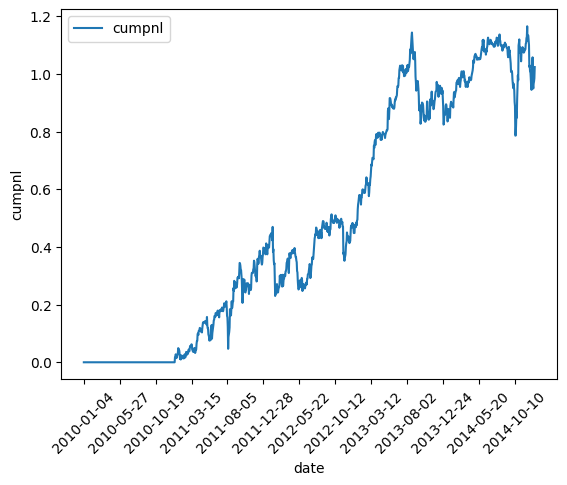

[0.0, 0.39406767005647036, 0.44834747481891035, 0.8584426426684181, 1.0239487343778453]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,NaN,0.003969,0.000000,0.000000
1,2011,1.581722,0.343067,0.164687,0.394068
2,2012,0.200145,0.459380,0.239556,0.448347
3,2013,1.513214,0.471266,0.319337,0.858443
4,2014,0.516452,0.337105,0.350878,1.023949


In [1450]:
alpha_19_data, alpha_19_cumpnl = AlphaStats(alpha_19, close_df)
alpha_19_data.head()

In [1451]:
test3(alpha_19_data)

Sharpe test not passed
Turnover test passed
Cumpnl test passed
passed 2 out of 3 tests


In [1452]:
alpha_19_pnl = alpha_income(alpha_19, INSTRUMENTS_RETURN)

In [1453]:
check_alpha_correlations(alphas, alpha_19_pnl)

mean_reverse:	0.13767669823296264
momentum_alpha:	0.1833676201194131
alpha_3:	-0.01904044858110232
alpha_4:	-0.01011577900248765
alpha_7:	-0.020724491780892435
alpha_8:	-0.07486895624747308
alpha_9:	0.08995885578525012
alpha_10:	0.06410475094747235
alpha_13:	0.00771913194719845
alpha_14:	0.07060672318310889
alpha_15:	-0.015190559124798109
alpha_16:	-0.007723103241589131
alpha_17:	0.009395271360112102


In [1454]:
# alphas.append(Alphas_Data('alpha_19', alpha_19_pnl))

## ALpha 20

**(((-1 * rank((open - delay(high, 1)))) * rank((open - delay(close, 1)))) * rank((open - delay(low, 1))))**

In [1455]:
def make_alpha_20(open_df, close_df, high_df, low_df, delay_window=1):
    close = close_df.drop(close_df.columns[0], axis=1).to_numpy().T
    open = open_df.drop(open_df.columns[0], axis=1).to_numpy().T
    high = high_df.drop(high_df.columns[0], axis=1).to_numpy().T
    low = low_df.drop(low_df.columns[0], axis=1).to_numpy().T

    alpha = np.zeros_like(close)
    for i in range(delay_window, len(close)):
        alpha[i] = -1 * mpa.rank(open[i] - high[i-delay_window]) *\
                    mpa.rank(open[i] - close[i-delay_window]) *\
                    mpa.rank(open[i] - low[i-delay_window])

    return alpha    

In [1456]:
delay_window = 1

alpha_20 = make_alpha_20(open_df, close_df, high_df, low_df, delay_window=1)
alpha_20 = decay(alpha_20, 3)

alpha_20 = neutralize(alpha_20)
alpha_20 = normalize(alpha_20)

test1(alpha_20)
test2(alpha_20[delay_window+1:])

Neutrality test passed
Normality test passed


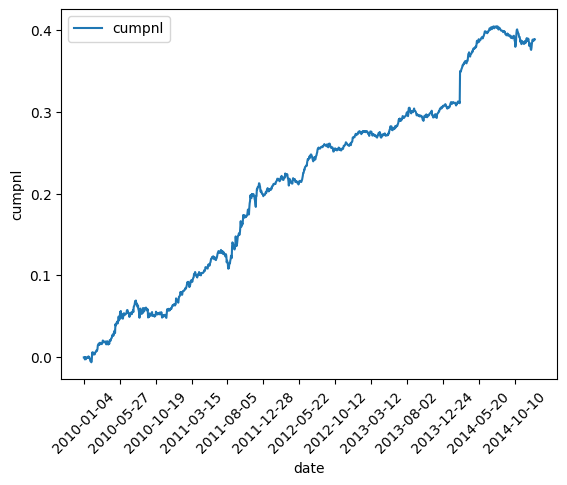

[0.06486884151824675, 0.19831504964501928, 0.2686274037813597, 0.3075956384402378, 0.38823502444432967]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,1.784809,0.722823,0.021200,0.064869
1,2011,2.997068,0.719538,0.022800,0.198315
2,2012,2.948553,0.724668,0.014778,0.268627
3,2013,1.693149,0.703629,0.016045,0.307596
4,2014,1.688170,0.710715,0.028851,0.388235


In [1457]:
alpha_20_data, alpha_20_cumpnl = AlphaStats(alpha_20, close_df)
alpha_20_data.head()

In [1458]:
test3(alpha_20_data)

Sharpe test passed
Turnover test passed
Cumpnl test passed
passed 3 out of 3 tests


In [1459]:
alpha_20_pnl = alpha_income(alpha_20, INSTRUMENTS_RETURN)

In [1460]:
check_alpha_correlations(alphas, alpha_20_pnl)

mean_reverse:	0.6255687694653657
momentum_alpha:	0.29121676673483615
alpha_3:	0.0070242832790024514
alpha_4:	0.0919735930702024
alpha_7:	-0.09505603872903401
alpha_8:	-0.20819634932163344
alpha_9:	0.22680808408602185
alpha_10:	0.15488785893282098
alpha_13:	-0.009850991440520413
alpha_14:	0.6065616554904936
alpha_15:	0.15291658014493278
alpha_16:	0.0791181648827099
alpha_17:	0.18674864671447686


In [1589]:
# alphas.append(Alphas_Data('alpha_20', alpha_20_pnl))

## Alpha 21

**((((sum(close, 8) / 8) + stddev(close, 8)) < (sum(close, 2) / 2)) ? (-1 * 1) : (((sum(close, 2) / 2) < ((sum(close, 8) / 8) - stddev(close, 8))) ? 1 : (((1 < (volume / adv20)) || ((volume / adv20) == 1)) ? 1 : (-1 * 1))))**

## Alpha 22

**(-1 * (delta(correlation(high, volume, 5), 5) * rank(stddev(close, 20))))**

In [1462]:
def make_alpha_22(close_df, high_df, volume_df, delta_window=5, corr_window=5, std_window=20):
    volume = volume_df.drop(volume_df.columns[0], axis=1).to_numpy().T
    close = close_df.drop(close_df.columns[0], axis=1).to_numpy().T
    high = high_df.drop(high_df.columns[0], axis=1).to_numpy().T

    close_std = np.zeros_like(close)
    for i in range(max(delta_window, std_window), len(close)):
        close_std[i] = mpa.rank(rolling_std(close[i-std_window:i]))

    corr_high_volume = np.zeros_like(close)
    for i in range(corr_window, len(close)):
        corr_high_volume[i] = ts_correlation(high[i-corr_window:i], volume[i-corr_window:i])

    alpha = np.zeros_like(close)
    for i in range(max(delta_window, std_window), len(close)):
        alpha[i] = -1 * (corr_high_volume[i] - corr_high_volume[i-delta_window]) * close_std[i]

    return alpha

In [1484]:
delta_window=5
corr_window=5
std_window=20

alpha_22 = make_alpha_22(close_df, high_df, volume_df, delta_window, corr_window, std_window)
# alpha_22 = mpa.truncate_alpha(alpha_22, 0.01)
alpha_22 = decay(alpha_22, 3)
alpha_22 = mpa.truncate_alpha(alpha_22, 0.2)

alpha_22 = neutralize(alpha_22)
alpha_22 = normalize(alpha_22)

test1(alpha_22)
test2(alpha_22[max(delta_window, std_window)+1:])

Neutrality test passed
Normality test passed


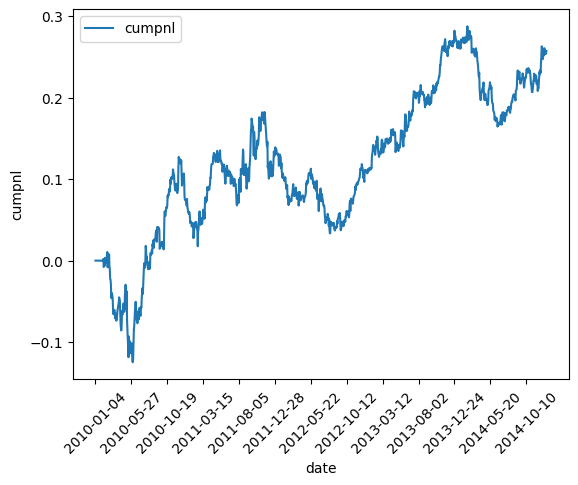

[0.07367366956034738, 0.13637546154190236, 0.1108508732305023, 0.27010802285898006, 0.25740725613512433]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,0.564335,0.509028,0.135341,0.073674
1,2011,0.482982,0.628544,0.081692,0.136375
2,2012,-0.300423,0.589058,0.102896,0.110851
3,2013,1.954429,0.647938,0.028208,0.270108
4,2014,-0.162745,0.680135,0.123104,0.257407


In [1485]:
alpha_22_data, alpha_22_cumpnl = AlphaStats(alpha_22, close_df)
alpha_22_data.head()

In [1486]:
test3(alpha_22_data)

Sharpe test not passed
Turnover test passed
Cumpnl test not passed
passed 1 out of 3 tests


In [1487]:
alpha_22_pnl = alpha_income(alpha_22, INSTRUMENTS_RETURN)

In [1488]:
check_alpha_correlations(alphas, alpha_22_pnl)

mean_reverse:	-0.03681684926535637
momentum_alpha:	0.007590181156918697
alpha_3:	0.05992724976175494
alpha_4:	-0.007960195799039248
alpha_7:	0.09288175107600177
alpha_8:	0.09315179914853453
alpha_9:	-0.08090422013120072
alpha_10:	-0.06714406739247332
alpha_13:	0.019956469971524865
alpha_14:	-0.06138022035018393
alpha_15:	-0.027145619260055646
alpha_16:	-0.012841522128508427
alpha_17:	-0.054676693292592754
alpha_20:	-0.11612737572844935


In [1489]:
# alphas.append(Alphas_Data('alpha_22', alpha_22_pnl))

## Alpha 23

**(((sum(high, 20) / 20) < high) ? (-1 * delta(high, 2)) : 0)**

In [1490]:
def make_alpha_23(high_df, sum_window=20, delta_window=2):
    high = high_df.drop(high_df.columns[0], axis=1).to_numpy().T

    alpha = np.zeros_like(high)
    for i in range(sum_window, len(high)):
        alpha[i] = np.where(high[i-sum_window:i].sum(axis=0) / 20 < high[i], -1 * (high[i] - high[i-delta_window]), 0)

    return alpha

In [1503]:
sum_window = 20
delta_window = 2

alpha_23 = make_alpha_23(high_df, sum_window, delta_window)
alpha_23 = mpa.decay(alpha_23, 10)
# alpha_23 = mpa.truncate_alpha(alpha_23, 0.1)

alpha_23 = neutralize(alpha_23)
alpha_23 = normalize(alpha_23)

test1(alpha_23)
test2(alpha_23[sum_window+1:])

Neutrality test passed
Normality test passed


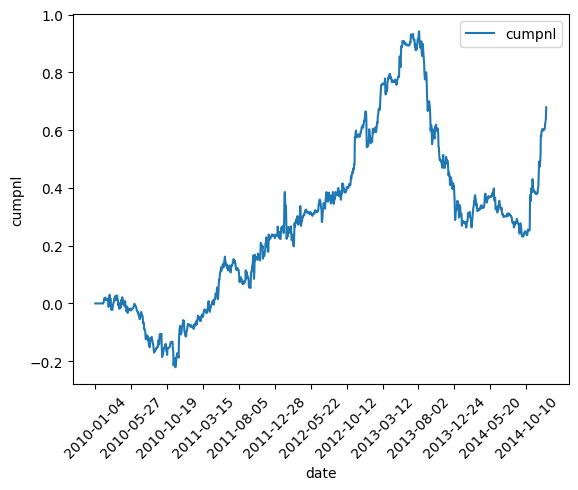

[-0.11405404685029114, 0.23524373684052696, 0.6638601456928641, 0.32286163441971244, 0.6791903100898131]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,-0.629936,0.195100,0.251031,-0.114054
1,2011,1.802538,0.230294,0.107959,0.235244
2,2012,1.729366,0.202912,0.188153,0.663860
3,2013,-1.245664,0.202586,0.653281,0.322862
4,2014,1.540500,0.224502,0.166427,0.679190


In [1504]:
alpha_23_data, alpha_23_cumpnl = AlphaStats(alpha_23, close_df)
alpha_23_data.head()

In [1505]:
test3(alpha_23_data)

Sharpe test passed
Turnover test passed
Cumpnl test passed
passed 3 out of 3 tests


In [1506]:
alpha_23_pnl = alpha_income(alpha_23, INSTRUMENTS_RETURN)

In [1546]:
check_alpha_correlations(alphas, alpha_23_pnl)

momentum_alpha:	0.012571045810112605
alpha_3:	0.03710159877596989
alpha_4:	0.015257554007315658
alpha_8:	0.06796478177119485
alpha_10:	-0.012462135071762163
alpha_13:	0.23367621620292955
alpha_14:	-0.0005867753207806735
alpha_15:	-0.08130110321832203
alpha_20:	0.019031366373656166


In [1632]:
alphas.append(Alphas_Data('alpha_23', alpha_23_pnl))

## Alpha 24

**((((delta((sum(close, 100) / 100), 100) / delay(close, 100)) < 0.05) || ((delta((sum(close, 100) / 100), 100) / delay(close, 100)) == 0.05)) ? (-1 * (close - ts_min(close, 100))) : (-1 * delta(close, 3)))**

## ALpha 25

**rank(((((-1 * returns) * adv20) * vwap) * (high - close)))**

In [383]:
def make_alpha_25(close_df, high_df, adv_window):
    pass

## Alpha 26

**(-1 * ts_max(correlation(ts_rank(volume, 5), ts_rank(high, 5), 5), 3))**

In [384]:
def make_alpha_26(volume_df, high_df, rank_window=5, corr_window=5, max_window=3):
    volume = volume_df.drop(volume_df.columns[0], axis=1).to_numpy().T
    high = high_df.drop(high_df.columns[0], axis=1).to_numpy().T

    volume_ranked = np.zeros_like(high)
    high_ranked = np.zeros_like(high)
    for i in range(rank_window, len(high)):
        volume_ranked[i] = ts_rank(volume[i-rank_window:i])
        high_ranked[i] = ts_rank(high[i-rank_window:i])

    corr_matrix = np.zeros_like(high)
    for i in range(corr_window, len(high)):
        if not np.array_equal(volume_ranked[i-corr_window:i], np.zeros_like(volume_ranked[i-corr_window:i])):
            corr_matrix[i] = ts_correlation(volume_ranked[i-corr_window:i], high_ranked[i-corr_window:i])


    alpha = np.zeros_like(high)
    for i in range(max(max_window, corr_window)+1, len(high)):
        alpha[i] = -1 * corr_matrix[i-1-max_window: i-1].max(axis=0)

    return alpha

In [385]:
rank_window=5
corr_window=5
max_window=3

alpha_26 = make_alpha_26(volume_df, high_df, rank_window, corr_window, max_window)

alpha_26 = neutralize(alpha_26)
alpha_26 = normalize(alpha_26)

test1(alpha_26)
test2(alpha_26[max(max_window, corr_window)+1:])

/Users/hubievkasym/Desktop/Sirius Uni/DerivativesControl/helper.py:383: RuntimeWarning: invalid value encountered in scalar divide
  corr = np.sum((alpha1 - alpha1.mean()) * (alpha2 - alpha2.mean()))/ (len(alpha1) - 1) / (std(alpha1) * std(alpha2))


Neutrality test passed
Normality test is not passed


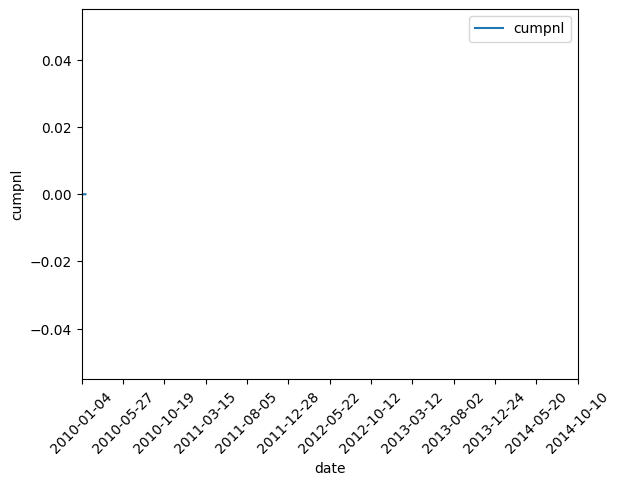

[nan, nan, nan, nan, nan]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,NaN,NaN,0.0,NaN
1,2011,NaN,NaN,0.0,NaN
2,2012,NaN,NaN,0.0,NaN
3,2013,NaN,NaN,0.0,NaN
4,2014,NaN,NaN,0.0,NaN


In [157]:
alpha_26_data, alpha_26_cumpnl = AlphaStats(alpha_26, close_df)
alpha_26_data.head()

In [158]:
test3(alpha_26_data)

Sharpe test not passed
Turnover tets not passed
Cumpnl test not passed
passed 0 out of 3 tests


## Alpha 27

**((0.5 < rank((sum(correlation(rank(volume), rank(vwap), 6), 2) / 2.0))) ? (-1 * 1) : 1)**

In [159]:
def make_alpha_27():
    pass

## Alpha 28

**scale(((correlation(adv20, low, 5) + ((high + low) / 2)) - close))**

In [386]:
def scale(matrix, a):
    for i in range(len(matrix)):
        if np.abs(matrix[i]).sum() != 0:
            matrix[i] = matrix[i] * 2 / np.abs(matrix[i]).sum()
    return matrix

In [1599]:
def make_alpha_28(high_df, low_df, close_df, volume_df, adv_window=20, corr_window=20, a=1):
    volume = volume_df.drop(volume_df.columns[0], axis=1).to_numpy().T
    close = close_df.drop(close_df.columns[0], axis=1).to_numpy().T
    high = high_df.drop(high_df.columns[0], axis=1).to_numpy().T
    low = low_df.drop(low_df.columns[0], axis=1).to_numpy().T

    adv = average_dayly_volume(volume, adv_window)
    _alpha = np.zeros_like(close)
    for i in range(adv_window + corr_window, len(close)):
        _alpha[i] = ts_correlation(adv[i - corr_window: i], low[i-corr_window: i-1]) +\
                                    (high[i] + low[i]) / 2 - close[i]
    
    return scale(_alpha, a)

In [1597]:
adv_window=20
corr_window=5

alpha_28 = make_alpha_28(high_df, low_df, close_df, volume_df, adv_window, corr_window)
alpha_28 = mpa.decay(alpha_28, 5)
alpha_28, zeros = mpa.CutOutliers(alpha_28, 10)
alpha_28, zeros_mid = mpa.CutMiddle(alpha_28, 10)
zeros = merge_zeros(zeros, zeros_mid)

alpha_28 = neutralize_with_dropout(alpha_28, zeros)
# alpha_28 = neutralize(alpha_28)
alpha_28 = normalize(alpha_28)

test1(alpha_28)
test2(alpha_28[adv_window + corr_window+1:])

Neutrality test passed
Normality test passed


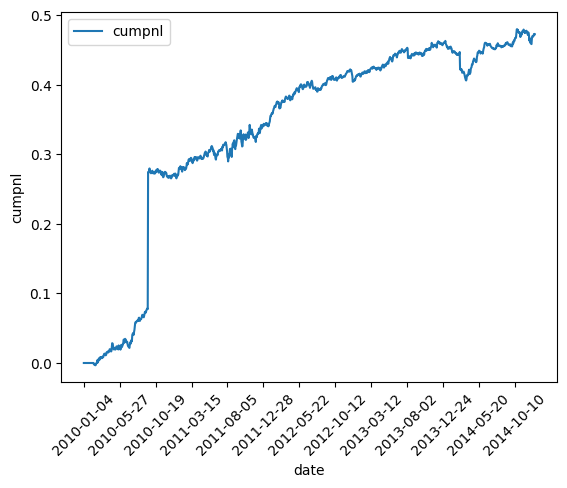

[0.27203375138963254, 0.34212467112236183, 0.40599890467173244, 0.46148005425517846, 0.472992569638496]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,1.366977,0.504395,0.014341,0.272034
1,2011,1.344837,0.527193,0.027620,0.342125
2,2012,2.159112,0.531832,0.017780,0.405999
3,2013,2.032769,0.541695,0.015177,0.461480
4,2014,0.292536,0.574900,0.056948,0.472993


In [1598]:
alpha_28_data, alpha_28_cumpnl = AlphaStats(alpha_28, close_df)
alpha_28_data.head()

In [1511]:
test3(alpha_28_data)

Sharpe test passed
Turnover test passed
Cumpnl test passed
passed 3 out of 3 tests


In [1512]:
alpha_28_pnl = alpha_income(alpha_28, INSTRUMENTS_RETURN)

In [1513]:
check_alpha_correlations(alphas, alpha_28_pnl)

mean_reverse:	-0.12379350121572165
momentum_alpha:	0.0899048303579738
alpha_3:	0.053989157241777094
alpha_4:	-0.004259858225990992
alpha_7:	-0.17630310670488358
alpha_8:	-0.16932104720181032
alpha_9:	0.13428076023721017
alpha_10:	0.07140447979221191
alpha_13:	0.05175188108816102
alpha_14:	-0.293900829887692
alpha_15:	-0.013799777831753476
alpha_16:	-0.01474537281050123
alpha_17:	0.12716228152587233
alpha_20:	-0.05347683359564429
alpha_23:	0.06948730999753257


In [1633]:
alphas.append(Alphas_Data('alpha_28', alpha_28_pnl))

## Alpha 29

**min[product{rank(rank[scale{log[sum{ts_min[rank{rank(-1 * rank{delta[close - 1, 5]})}, 2], 1}]}]), 1}, 5] + ts_rank{delay[-1 * returns, 6], 5}**

In [1176]:
def make_alpha_29(close_df, returns_shift):
    close = close_df.drop(close_df.columns[0], axis=1).to_numpy().T
    returns = instrument_return(close_prices=close)

    returns_shifted = np.concatenate((np.zeros((returns_shift, close.shape[1])), returns[returns_shift:]))
    returns_ranked = np.zeros_like(close)

## Alpha 30

**(((1.0 - rank(((sign((close - delay(close, 1))) + sign((delay(close, 1) - delay(close, 2)))) + sign((delay(close, 2) - delay(close, 3)))))) * sum(volume, 5)) / sum(volume, 20))**

In [452]:
def make_alpha_30():
    pass

In [1851]:
for _alpha in alphas:
    print(_alpha.name, '\n')
    check_alpha_correlations(alphas, _alpha.cumpnl)
    print('\n\n')

momentum_alpha 

momentum_alpha:	1.0
alpha_3:	-0.04166141494282541
alpha_4:	0.0006244363270502071
alpha_8:	-0.24047376285597188
alpha_10:	0.18829042295403714
alpha_13:	-0.1911542586228575
alpha_14:	0.46208781438568286
alpha_15:	-0.005740286372564484
alpha_23:	0.012571045810112605
alpha_28:	0.0899048303579738



alpha_3 

momentum_alpha:	-0.04166141494282541
alpha_3:	1.0000000000000002
alpha_4:	0.0280037836231019
alpha_8:	0.027395299218835704
alpha_10:	-0.04326075035143603
alpha_13:	0.08935202595545325
alpha_14:	0.0071968321356487615
alpha_15:	0.014034636379879102
alpha_23:	0.04044238398311901
alpha_28:	0.06392841162373814



alpha_4 

momentum_alpha:	0.0006244363270502071
alpha_3:	0.0280037836231019
alpha_4:	1.0
alpha_8:	-0.015571830301229684
alpha_10:	0.012916888932225945
alpha_13:	0.005835714684117814
alpha_14:	0.1052021633134424
alpha_15:	0.02619427880193412
alpha_23:	0.015257554007315658
alpha_28:	-0.004259858225990992



alpha_8 

momentum_alpha:	-0.24047376285597188
alpha_3:	0.02

In [1634]:
corrs = [] 
for _alpha in alphas[:]:
    res = []
    for __alpha in alphas[:]:
        res.append(calc_alphas_corr(_alpha.cumpnl, __alpha.cumpnl))
    corrs.append(res)

<Axes: >

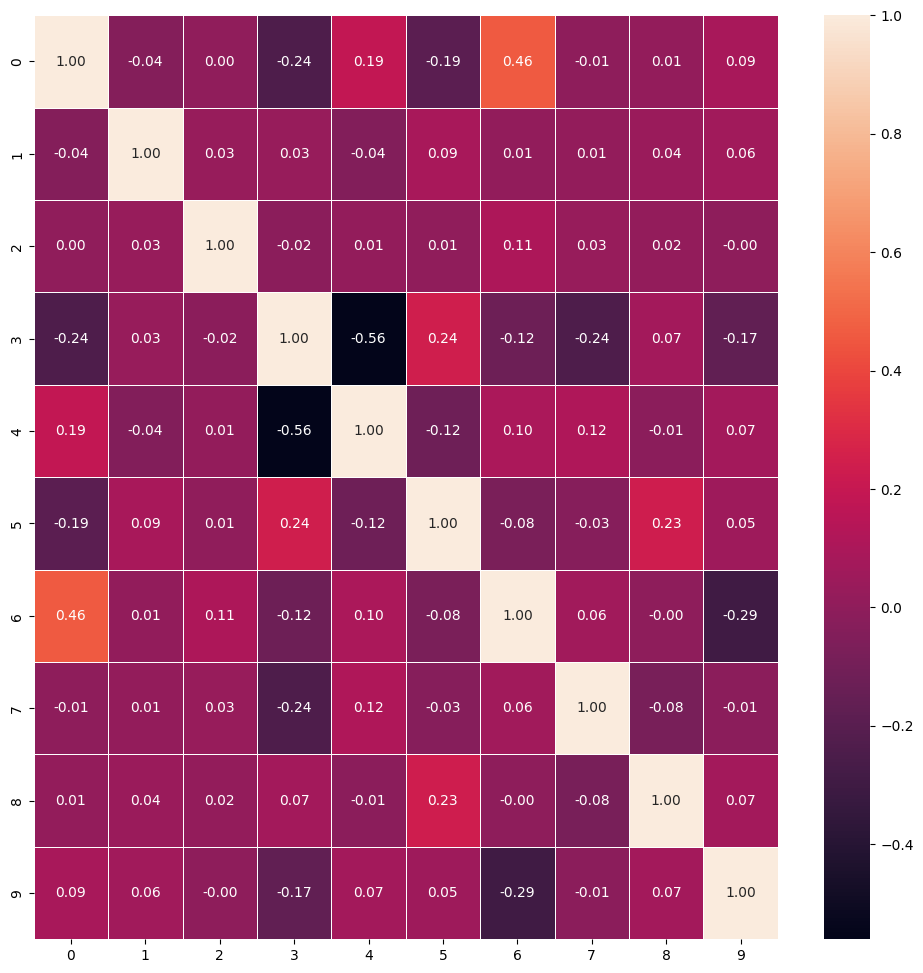

In [1635]:
# import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,12)) 
sns.heatmap(corrs, annot=True, fmt=".2f",linewidth=.5)

In [1567]:
for idx, _alpha in enumerate(alphas[:]):
    print(idx, _alpha.name)

print(f'\nTotal: {len(alphas)} alphas')

0 momentum_alpha
1 alpha_3
2 alpha_4
3 alpha_8
4 alpha_10
5 alpha_13
6 alpha_14
7 alpha_15
8 alpha_23
9 alpha_28

Total: 10 alphas


<Axes: >

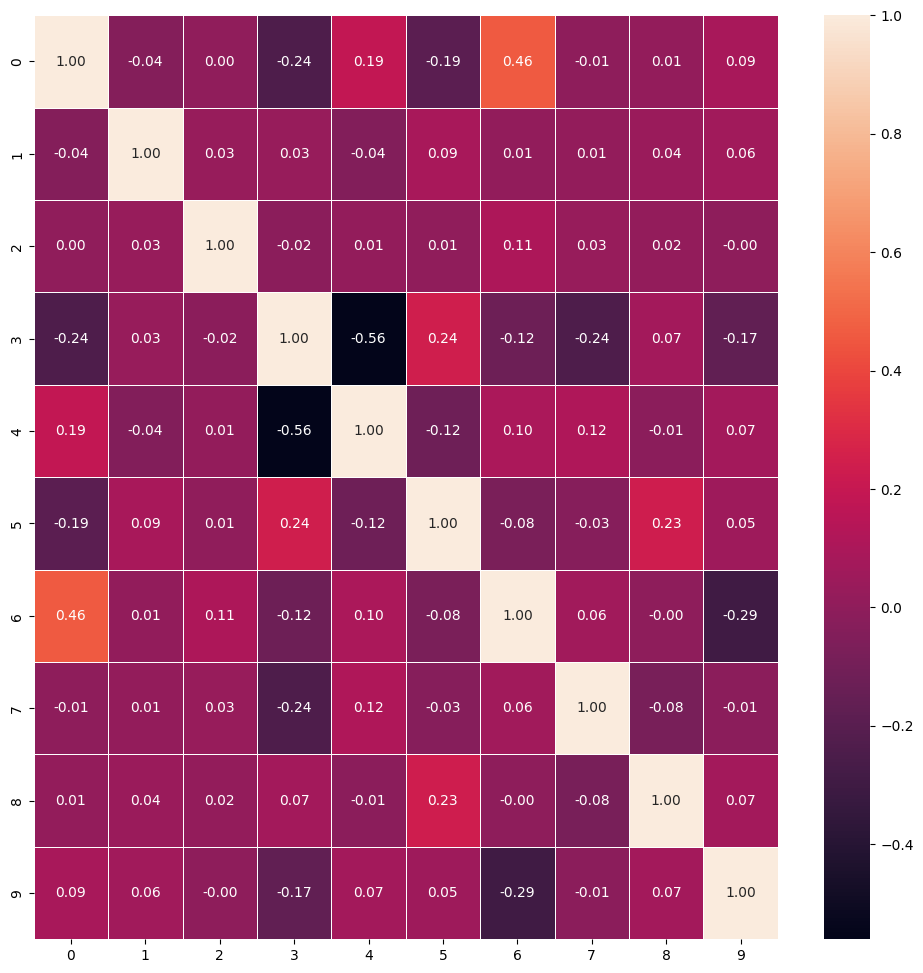

In [1737]:
fig, ax = plt.subplots(figsize=(12,12)) 
sns.heatmap(corrs, annot=True, fmt=".2f",linewidth=.5)

In [1594]:
for idx, _alpha in enumerate(alphas[:]):
    print(idx, _alpha.name)

print(f'\nTotal: {len(alphas)} alphas')

0 mean_reverse
1 momentum_alpha
2 alpha_3
3 alpha_4
4 alpha_7
5 alpha_8
6 alpha_9
7 alpha_10
8 alpha_13
9 alpha_14
10 alpha_15
11 alpha_16
12 alpha_17
13 alpha_20
14 alpha_23
15 alpha_28

Total: 16 alphas


# Портфели

In [1637]:
for idx, _alpha in enumerate(alphas[:]):
    print(idx, _alpha.name)

print(f'\nTotal: {len(alphas)} alphas')

0 momentum_alpha
1 alpha_3
2 alpha_4
3 alpha_8
4 alpha_10
5 alpha_13
6 alpha_14
7 alpha_15
8 alpha_23
9 alpha_28

Total: 10 alphas


In [1862]:
alphas_portfolio = [momentum_alpha, 
                    alpha_3, 
                    alpha_4, 
                    # alpha_8, 
                    alpha_10, 
                    alpha_13, 
                    # alpha_14, 
                    alpha_15, 
                    alpha_23, 
                    # alpha_28
                   ]

alphas_datas = [momentum_alpha_data, 
                alpha_3_data, 
                alpha_4_data, 
                # alpha_8_data, 
                alpha_10_data, 
                alpha_13_data, 
                # alpha_14_data, 
                alpha_15_data, 
                alpha_23_data, 
                # alpha_28_data
               ]

## An Uniform portfolio

In [1823]:
uniform_portfolio = np.zeros_like(momentum_alpha)
for _alpha in alphas_portfolio:
    uniform_portfolio += 1/ len(alphas_portfolio) * _alpha

uniform_portfolio = normalize(uniform_portfolio)

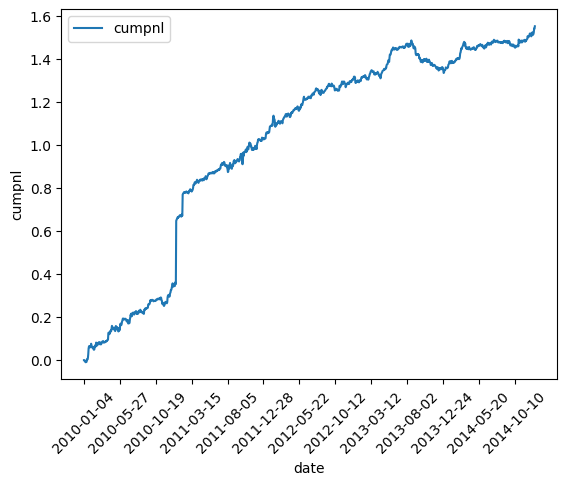

[0.34414337066071693, 1.0294714733521502, 1.316890772399085, 1.3475419600586467, 1.5510809795732032]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,3.224892,0.493616,0.039656,0.344143
1,2011,2.090663,0.415963,0.048591,1.029471
2,2012,3.007468,0.375896,0.051457,1.316891
3,2013,0.331002,0.351972,0.151200,1.347542
4,2014,2.424891,0.372471,0.037144,1.551081


In [1824]:
uniform_portfolio_data, uniform_portfolio_cumpnl = AlphaStats(uniform_portfolio, close_df)
uniform_portfolio_data.head()

In [1825]:
test3(uniform_portfolio_data)

Sharpe test passed
Turnover test passed
Cumpnl test passed
passed 3 out of 3 tests


In [1826]:
uniform_portfolio_pnl = alpha_income(uniform_portfolio, INSTRUMENTS_RETURN)

## A PrevSharpe Weighted Portfolio

In [1834]:
sharpe_portfolio = np.zeros_like(momentum_alpha)
factors = normalize(np.array([_data['Sharpe'].values[-2] for _data in alphas_datas]))
for _alpha, _factor in zip(alphas_portfolio, factors):
    sharpe_portfolio += _factor * _alpha

sharpe_portfolio = normalize(sharpe_portfolio)

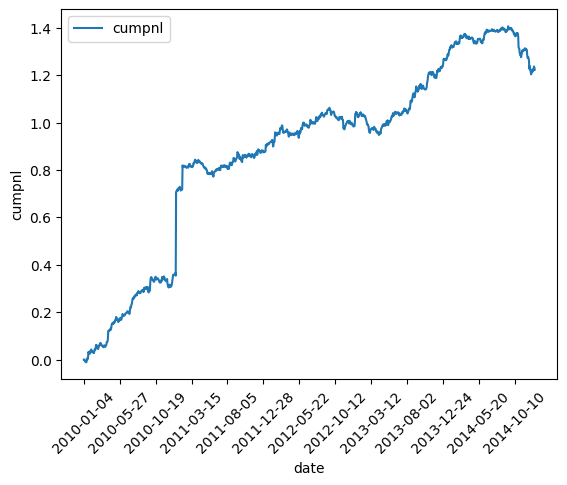

[0.3566844144144811, 0.8754836024928194, 0.9848182532833434, 1.2648352021076255, 1.2230494609913374]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,3.568357,0.508676,0.046898,0.356684
1,2011,1.375960,0.456118,0.071767,0.875484
2,2012,1.052064,0.421633,0.091203,0.984818
3,2013,2.615804,0.410109,0.096716,1.264835
4,2014,-0.392967,0.412265,0.202884,1.223049


In [1835]:
sharpe_portfolio_data, sharpe_portfolio_cumpnl = AlphaStats(sharpe_portfolio, close_df)
sharpe_portfolio_data.head()

In [1836]:
test3(sharpe_portfolio_data)

Sharpe test passed
Turnover test passed
Cumpnl test passed
passed 3 out of 3 tests


In [1837]:
sharpe_portfolio_pnl = alpha_income(sharpe_portfolio, INSTRUMENTS_RETURN)

# A Sharply Weighted Portfolio

In [1838]:
def build_sharpe_portfolio(df: pd.DataFrame, alphas, alphas_data):
    portfolio = np.zeros_like(alphas[0])
    # portfolio_factors = []
    # indexes = []
    
    format = '%Y-%m-%d'
    year_start = '-01-01'
    year_end = '-12-31'

    # get all dates list
    dates = df.columns[1:]

    # get unique years in dates list
    dates_years = np.unique(np.array([date.split('-')[0] for date in dates]))

    # convert date strings into datetime.date to compare
    dates = np.array(pd.to_datetime(dates,format='%Y-%m-%d').date)

    # make years borders
    years_borders = np.array([(datetime.datetime.strptime(year+year_start, format).date(), 
                      datetime.datetime.strptime(year+year_end, format).date()) for year in dates_years])

    # get instruments return matrix 
    return_matrix = instrument_return(df)


    for idx, year_date in enumerate(years_borders):
        start, end = year_date
        _factors = []
        
        # get indexes of the current year
        indexes = np.where((start <= dates) & (end >= dates) , True, False)

        # indexes.append(indexes)

        for _alpha, _data in zip(alphas, alphas_data):

            if idx == 0:
                factor = 1 / len(alphas)
            else:
                factor = _data['Sharpe'].values[idx-1]

            _factors.append(factor)

            # portfolio[indexes] += factor * _alpha[indexes]

        # portfolio_factors.append(_factors)

        _factors = normalize(np.array(_factors))
        for _factor in _factors:
            portfolio[indexes] += _factor * _alpha[indexes]
            
            
    return portfolio

In [1839]:
sharply_portfolio = build_sharpe_portfolio(close_df, alphas_portfolio, alphas_datas)

sharply_portfolio = normalize(sharply_portfolio)

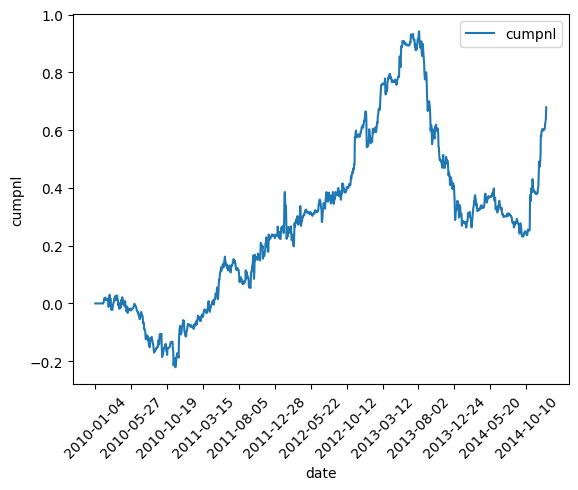

[-0.11405404685029122, 0.23524373684052682, 0.6638601456928639, 0.3228616344197122, 0.6791903100898129]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,-0.629936,0.195100,0.251031,-0.114054
1,2011,1.802538,0.230294,0.107959,0.235244
2,2012,1.729366,0.202912,0.188153,0.663860
3,2013,-1.245664,0.202586,0.653281,0.322862
4,2014,1.540500,0.224502,0.166427,0.679190


In [1840]:
sharply_portfolio_data, sharply_portfolio_cumpnl = AlphaStats(sharply_portfolio, close_df)
sharply_portfolio_data.head()

In [1841]:
test3(sharply_portfolio_data)

Sharpe test passed
Turnover test passed
Cumpnl test passed
passed 3 out of 3 tests


In [1842]:
sharply_portfolio_pnl = alpha_income(sharply_portfolio, INSTRUMENTS_RETURN)

# An Income proportional Alpha

In [1816]:
from helper import cumulative_pnl

In [1817]:
def build_income_portfolio(df: pd.DataFrame, alphas, alphas_data):
    portfolio = np.zeros_like(alphas[0])
    
    format = '%Y-%m-%d'
    year_start = '-01-01'
    year_end = '-12-31'

    # get all dates list
    dates = df.columns[1:]

    # get unique years in dates list
    dates_years = np.unique(np.array([date.split('-')[0] for date in dates]))

    # convert date strings into datetime.date to compare
    dates = np.array(pd.to_datetime(dates,format='%Y-%m-%d').date)

    # make years borders
    years_borders = np.array([(datetime.datetime.strptime(year+year_start, format).date(), 
                      datetime.datetime.strptime(year+year_end, format).date()) for year in dates_years])

    # get instruments return matrix 
    return_matrix = instrument_return(df)


    for idx, year_date in enumerate(years_borders):
        start, end = year_date
        _factors = []

        # get indexes of the current year
        current_year_indexes = np.where((start <= dates) & (end >= dates) , True, False)

        for _alpha, _data in zip(alphas, alphas_data):

            if idx == 0:
                factor = 1 / len(alphas)
            elif idx == 1:
                factor = _data['Cumpnl'].values[idx-1]
            else:
                factor = _data['Cumpnl'].values[idx-1] - _data['Cumpnl'].values[idx-2]

            _factors.append(factor)

        _factors = normalize(np.array(_factors))

        for _factor in factors:
            portfolio[current_year_indexes] += _factor * _alpha[current_year_indexes]
            
    return portfolio

In [1818]:
income_portfolio = build_income_portfolio(close_df, alphas_portfolio, alphas_datas)

income_portfolio = normalize(income_portfolio)

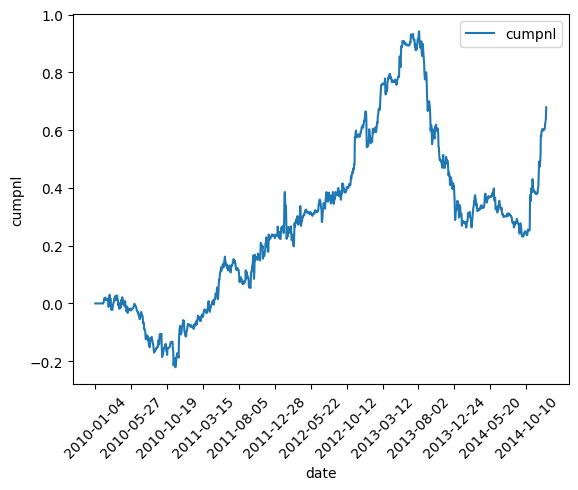

[-0.11405404685029123, 0.2352437368405268, 0.6638601456928639, 0.3228616344197122, 0.6791903100898129]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,-0.629936,0.195100,0.251031,-0.114054
1,2011,1.802538,0.230294,0.107959,0.235244
2,2012,1.729366,0.202912,0.188153,0.663860
3,2013,-1.245664,0.202586,0.653281,0.322862
4,2014,1.540500,0.224502,0.166427,0.679190


In [1843]:
income_portfolio_data, income_portfolio_cumpnl = AlphaStats(income_portfolio, close_df)
income_portfolio_data.head()

In [1844]:
test3(income_portfolio_data)

Sharpe test passed
Turnover test passed
Cumpnl test passed
passed 3 out of 3 tests


In [1846]:
income_portfolio_pnl = alpha_income(income_portfolio, INSTRUMENTS_RETURN)

# Markowitz

In [1877]:
def covariance_matrix(alphas, instruments_return):
    cov = np.zeros((len(alphas), len(alphas)))

    for i in range(len(alphas)):
        for j in range(len(alphas)):
            cov[i][j] = covarience(alpha_income(alphas[i], INSTRUMENTS_RETURN), alpha_income(alphas[j], INSTRUMENTS_RETURN))
            # cov[i][j] = calc_alphas_corr(alpha_income(alphas[i], INSTRUMENTS_RETURN), alpha_income(alphas[j], INSTRUMENTS_RETURN))

    return cov

In [1878]:
from scipy.optimize import minimize

In [1922]:
cov_matrix = covariance_matrix(alphas_portfolio, INSTRUMENTS_RETURN)
# fig, ax = plt.subplots(figsize=(12,12)) 
# sns.heatmap(cov_matrix, annot=True, fmt=".2f",linewidth=.5)
def min_function(x, C):
    return np.dot(np.dot(x, C),x.T)

# cons = ({'type': 'ineq', 'fun': lambda x:  np.where(x < 0, 1, 0).sum() == 0})
cons = ({'type': 'eq', 'fun': lambda x:  x.sum() - 1})
        # {'type': 'ineq', 'fun': lambda x: -x[0] - 2 * x[1] + 6},
        # {'type': 'ineq', 'fun': lambda x: -x[0] + 2 * x[1] + 2})

bnds = tuple([(0, None) for _ in range(len(alphas_portfolio))])

x_vec = np.random.rand(len(alphas_portfolio))
res = minimize(lambda x: min_function(x, cov_matrix), x_vec, method='SLSQP', bounds=bnds, constraints=cons)

In [1927]:
np.abs(res.x).sum()

1.0000000000000002

In [1924]:
factors = res.x

In [1925]:
marcovitz_portfolio = np.zeros_like(alphas_portfolio[0])
for _factor, _alpha in zip(factors, alphas_portfolio):
    marcovitz_portfolio += _factor * _alpha

marcovitz_portfolio = normalize(marcovitz_portfolio)

marcovitz_portfolio.shape

(1257, 2436)

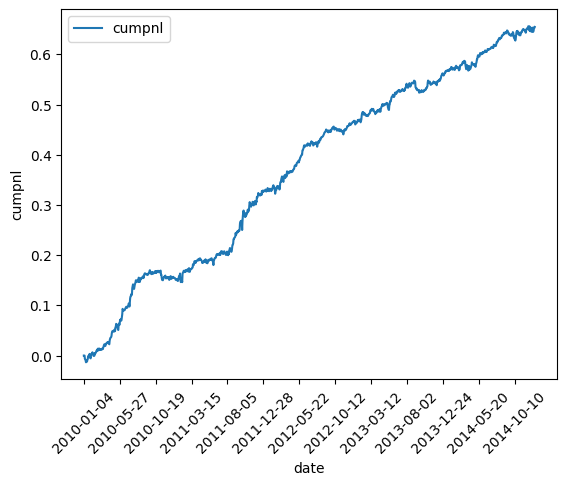

[0.15479217175254564, 0.3281921154081187, 0.4676610753397684, 0.5622835691989823, 0.6547891132868631]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,3.345391,0.487564,0.020105,0.154792
1,2011,2.997581,0.431836,0.018345,0.328192
2,2012,3.569220,0.397124,0.016901,0.467661
3,2013,2.436686,0.379431,0.023983,0.562284
4,2014,2.236922,0.387176,0.020130,0.654789


In [1926]:
marcovitz_portfolio_data, marcovitz_portfolio_cumpnl = AlphaStats(marcovitz_portfolio, close_df)
marcovitz_portfolio_data.head()

In [1918]:
marcovitz_portfolio_pnl = alpha_income(marcovitz_portfolio, INSTRUMENTS_RETURN)

In [1917]:
test3(marcovitz_portfolio_data)

Sharpe test passed
Turnover test passed
Cumpnl test passed
passed 3 out of 3 tests


# A Risk Budgeting alpha

In [1946]:
cov_matrix = covariance_matrix(alphas_portfolio, INSTRUMENTS_RETURN)

np.dot(np.dot(x_vec, cov_matrix),x_vec.T)
np.dot(x_vec.T, cov_matrix)

array([0.02312978, 0.01737699, 2.02840908, 0.2114204 , 0.00696905,
       0.01962773, 0.20395279])

In [1991]:
def risk_function(x, C):
    # risk = np.sqrt(np.dot(np.dot(x, C),x.T))
    # dx = np.dot(x.T, C) / risk
    # return np.dot(x,dx.T) - risk
    return .5 * np.dot(np.dot(x, C),x.T) - (1 / len(x)) * np.log(np.abs(x)).sum()

# cons = ({'type': 'ineq', 'fun': lambda x:  np.where(x < 0, 1, 0).sum() == 0})
cons = ({'type': 'eq', 'fun': lambda x:  np.where(x < 0, 1, 0).sum()})
        # {'type': 'ineq', 'fun': lambda x: -x[0] - 2 * x[1] + 6},
        # {'type': 'ineq', 'fun': lambda x: -x[0] + 2 * x[1] + 2})

bnds = tuple([(1e-6, None) for _ in range(len(alphas_portfolio))])

x_vec = np.abs(np.random.rand(len(alphas_portfolio)))
res = minimize(lambda x: risk_function(x, cov_matrix), x_vec, method='SLSQP', constraints=cons) # bounds=bnds

In [1992]:
np.abs(res.x).sum()
res.x

array([0.23293735, 0.61076015, 0.96346673, 0.86772953, 0.73630076,
       0.43017677, 0.30013309])

In [1993]:
factors = normalize(res.x)
risk_budgeting_portfolio = np.zeros_like(alphas_portfolio[0])
for _factor, _alpha in zip(factors, alphas_portfolio):
    risk_budgeting_portfolio += _factor * _alpha

risk_budgeting_portfolio = normalize(risk_budgeting_portfolio)

risk_budgeting_portfolio.shape

(1257, 2436)

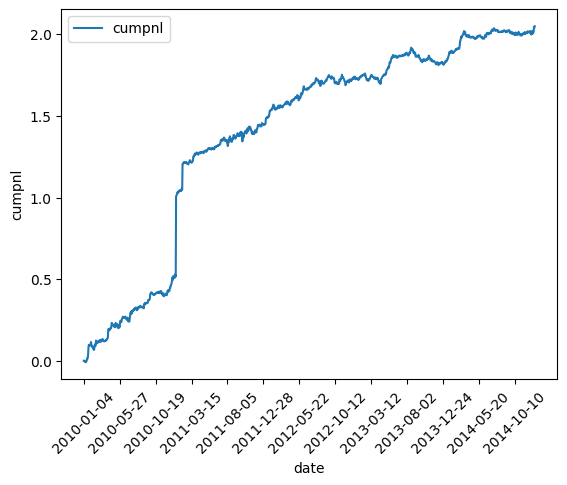

[0.5075918306860396, 1.448920120845441, 1.739054124153315, 1.8258084737569797, 2.049353661481157]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,3.569404,0.472463,0.048638,0.507592
1,2011,1.776488,0.386655,0.059195,1.448920
2,2012,2.494604,0.350298,0.064187,1.739054
3,2013,0.868101,0.323781,0.107771,1.825808
4,2014,2.252451,0.349996,0.047093,2.049354


In [1994]:
risk_budgeting_portfolio_data, risk_budgeting_portfolio_cumpnl = AlphaStats(risk_budgeting_portfolio, close_df)
risk_budgeting_portfolio_data.head()

In [1966]:
test3(risk_budgeting_portfolio_data)

Sharpe test passed
Turnover test passed
Cumpnl test passed
passed 3 out of 3 tests


In [1952]:
risk_budgeting_portfolio_pnl = alpha_income(risk_budgeting_portfolio, INSTRUMENTS_RETURN)

In [1847]:
calc_alphas_corr(uniform_portfolio_pnl, sharpe_portfolio_pnl)

0.7130338819499432

In [1848]:
calc_alphas_corr(uniform_portfolio_pnl, sharply_portfolio_pnl)

0.3500257611456205

In [1849]:
calc_alphas_corr(sharply_portfolio_pnl, sharpe_portfolio_pnl)

-0.34373214302416

In [1919]:
calc_alphas_corr(marcovitz_portfolio_pnl, sharpe_portfolio_pnl)

-0.06986560289170864

In [1920]:
calc_alphas_corr(marcovitz_portfolio_pnl, sharply_portfolio_pnl)

0.2327333302778692

In [1921]:
calc_alphas_corr(uniform_portfolio_pnl, marcovitz_portfolio_pnl)

0.2043883153219798

In [1953]:
portfolios = [uniform_portfolio_pnl, sharpe_portfolio_pnl, sharply_portfolio_pnl, marcovitz_portfolio_pnl, risk_budgeting_portfolio_pnl]

corrs = []
for _portfolio in portfolios:
    res = []
    for __portfolio in portfolios:
        res.append(calc_alphas_corr(_portfolio, __portfolio))
    corrs.append(res)